In [2]:
# Importing the necessary libraries for the project. 
import pandas as pd 
import yfinance as yf
import numpy as np # for numerical operations
import seaborn as sns #visualisation
import matplotlib.pyplot as plt # visualization
%matplotlib inline 
import matplotlib.ticker as ticker # Library to customize ticks
from datetime import date
import matplotlib.dates as mdates
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from math import sqrt
# ParameterSampler for randomized hyperparameter sampling, optimizing model parameters in cross-validation.
from sklearn.model_selection import ParameterSampler
# pmdarima's auto_arima for automated selection of the best ARIMA parameters based on AIC/BIC scores.
from pmdarima import auto_arima
# TimeSeriesSplit for cross-validation with time series data to preserve the temporal ordering of data.
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
# Mean Squared Error and Mean Absolute Error metrics from sklearn for evaluating model accuracy.
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterSampler
from tensorflow.keras.optimizers import Adam
from keras.layers import BatchNormalization, Dropout, Dense, LSTM, GRU
import random
import optuna
from optuna.samplers import TPESampler
from keras_tuner import BayesianOptimization

import warnings # filter warnings
warnings.filterwarnings('ignore')

In [3]:
# Importing the dataset after the Log Returns transformation.
df1 = pd.read_csv('df1.csv', index_col=0, parse_dates=True)

# Along with the importation, the code will set the date as the index, value of 0 because is the first column.
## Setting parse_dates=true to ensure the dates are in datetime, making more appropriate for ML models.

In [4]:
df1.head()

,Close,lag_1,lag_4,rolling_mean_4w,rolling_mean_12w,volatility_4w
Date,,,,,,
2004-04-01,0.012635,0.031461,-0.023861,0.003674,0.000735,117.596902
2004-04-08,-0.010896,0.012635,-0.000125,0.000981,-0.001424,117.741650
2004-04-15,-0.003623,-0.010896,-0.029274,0.007394,-0.000325,0.776477
2004-04-22,-0.001496,-0.003623,0.031461,-0.000845,-0.000305,0.623353
2004-04-29,-0.000784,-0.001496,0.012635,-0.004200,-0.002649,0.647610


In [5]:
df1.describe()

,Close,lag_1,lag_4,rolling_mean_4w,rolling_mean_12w,volatility_4w
count,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000
mean,0.001575,0.001608,0.001508,0.001578,0.001516,7.731465
std,0.020723,0.020744,0.020750,0.009796,0.005364,23.505939
min,-0.069935,-0.069935,-0.069935,-0.051352,-0.026288,0.154122
25%,-0.007633,-0.007633,-0.007858,-0.003032,-0.001013,1.538535
50%,0.003635,0.003666,0.003626,0.002937,0.002346,2.585030
75%,0.013568,0.013643,0.013514,0.007596,0.004979,6.157669
max,0.051947,0.051947,0.051947,0.031089,0.019145,338.128664


In [6]:
# Define the selected exogenous variables
ex1 = df1[['rolling_mean_4w', 'rolling_mean_12w', 'volatility_4w', 'lag_1', 'lag_4']]

In [12]:
# Define the split index for the train-test split (85% train, 15% test)
split_index = int(0.85 * len(df1))

# Target variable split
train = df1['Close'][:split_index]
test = df1['Close'][split_index:]

# Exogenous variables split
exo_train = ex1[['rolling_mean_4w', 'rolling_mean_12w', 'volatility_4w', 'lag_1', 'lag_4']][:split_index]
exo_test = ex1[['rolling_mean_4w', 'rolling_mean_12w', 'volatility_4w', 'lag_1', 'lag_4']][split_index:]

## model - order=(1, 0, 3), seasonal_order=(1, 0, 2, 52) 
- p/d/q order extracted from the best parameters from the SARIMAX notebook.
- The parameters are the same as the baseline model (Best accuracy metrics across 4 different seasonalities).

                                        SARIMAX Results                                        
Dep. Variable:                                   Close   No. Observations:                  876
Model:             SARIMAX(1, 0, 3)x(1, 0, [1, 2], 52)   Log Likelihood                2537.512
Date:                                 Fri, 06 Dec 2024   AIC                          -5049.025
Time:                                         13:17:35   BIC                          -4986.945
Sample:                                     04-01-2004   HQIC                         -5025.279
                                          - 01-07-2021                                         
Covariance Type:                                   opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rolling_mean_4w      1.4156      0.097     14.645      0.000  

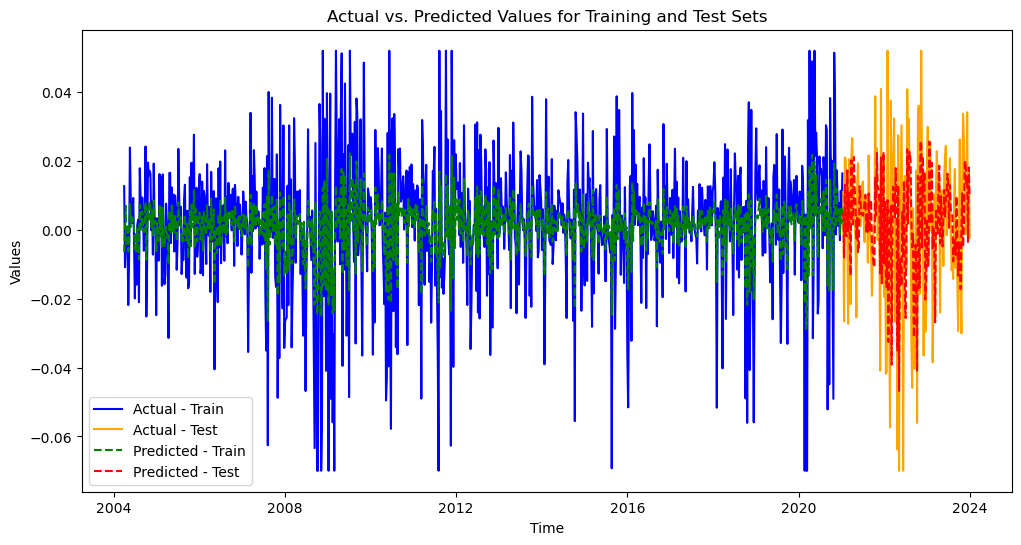

In [14]:
# Define SARIMAX model.
sarimax_model = SARIMAX(train, order=(1, 0, 3), seasonal_order=(1, 0, 2, 52), exog=exo_train)
sarimax_final_52 = sarimax_model.fit(disp=False)

# Print summary.
print(sarimax_final_52.summary())

# Calculate RMSE on training data.
train_predictions = sarimax_final_52.predict(start=0, end=len(train)-1, exog=exo_train)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data.
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data.
test_predictions = sarimax_final_52.forecast(steps=len(test), exog=exo_test)
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data.
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data.
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data.
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics.
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set.
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

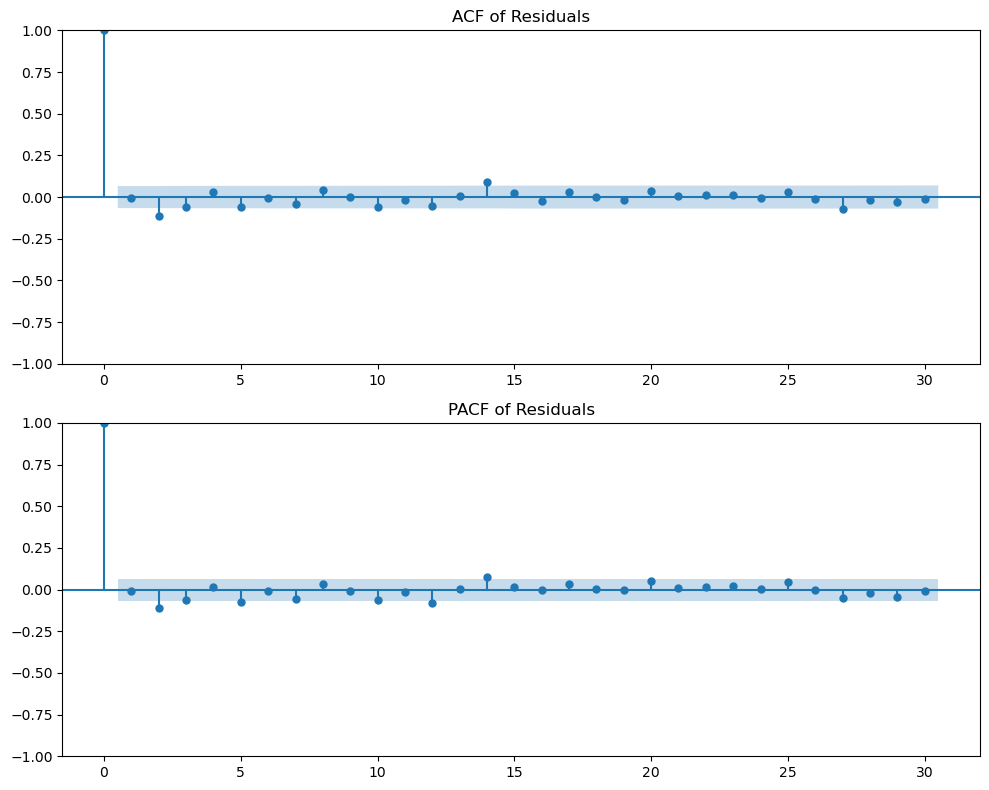

In [15]:
# Calculate residuals from the fitted model.
residuals_52 = sarimax_final_52.resid

# Plot ACF and PACF for residuals.
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
sm.graphics.tsa.plot_acf(residuals_52, lags=30, ax=ax[0])
ax[0].set_title('ACF of Residuals')
sm.graphics.tsa.plot_pacf(residuals_52, lags=30, ax=ax[1])
ax[1].set_title('PACF of Residuals')
plt.tight_layout()
plt.show()

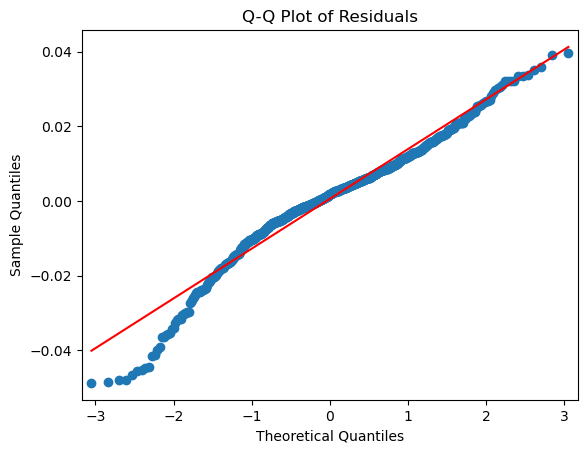

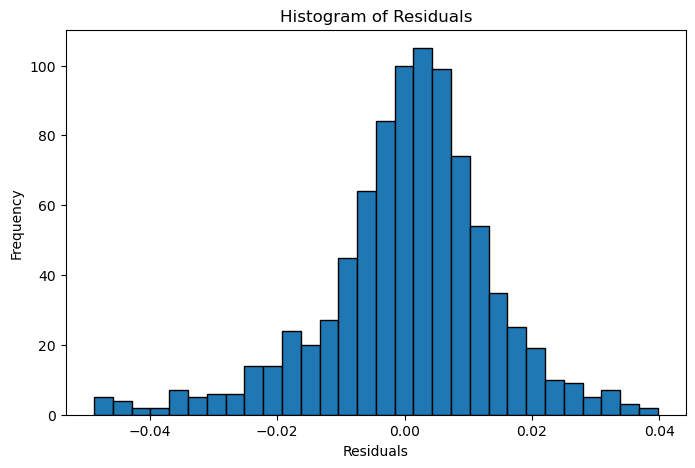

In [11]:
# Q-Q plot for normality check.
sm.qqplot(residuals_52, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

# Histogram of residuals.
plt.figure(figsize=(8, 5))
plt.hist(residuals_52, bins=30, edgecolor='k')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

In [12]:
# Ljung-Box test for autocorrelation.
ljung_box_results = acorr_ljungbox(residuals_52, lags=[10, 20, 30], return_df=True)
print(ljung_box_results) # prints the results.

# Arch test for heteroscedasticity 
arch_test_stat, arch_pvalue, _, _ = het_arch(residuals_52)
print("ARCH Test p-value:", arch_pvalue) # prints the arch results

      lb_stat  lb_pvalue
10  24.333845   0.006762
20  37.871745   0.009181
30  44.706827   0.041094
ARCH Test p-value: 7.96929136614076e-24


In [13]:
residuals_52.describe()

count    876.000000
mean       0.000569
std        0.013350
min       -0.048768
25%       -0.005453
50%        0.001800
75%        0.008253
max        0.039730
dtype: float64

In [16]:
# Test residuals: Actual test values - SARIMAX test predictions
test_residuals = test - test_predictions

# Check lengths to ensure alignment
print(f"Length of test_residuals: {len(test_residuals)}")

Length of test_residuals: 155


In [15]:
test_residuals.describe()

count    155.000000
mean       0.000062
std        0.019189
min       -0.061776
25%       -0.011712
50%       -0.000744
75%        0.011773
max        0.046612
dtype: float64

PREPING THE RESIDUALS

In [17]:
# Use SARIMAX residuals directly from the original train-test split
y_train = residuals_52  # Residuals are already from the SARIMAX training set
y_test = test_residuals  # Residuals for testing

# Scale residuals for LSTM
scaler = RobustScaler()
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))  # Scale entire train residuals

# Scale the test residuals (optional, depends on hybrid combination process)
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

# Print minimum and maximum values of the scaled data for verification
print("Scaled Training Residuals - Min:", y_train_scaled.min(), "Max:", y_train_scaled.max())
print("Scaled Test Residuals - Min:", y_test_scaled.min(), "Max:", y_test_scaled.max())

Scaled Training Residuals - Min: -3.6894921631325186 Max: 2.7673603991969826
Scaled Test Residuals - Min: -4.638548414741479 Max: 3.269497284770579


## Sequence Length = 4

In [100]:
# Reshape residual data into sequences for LSTM.
sequence_length = 4  # Number of time steps used for target prediction.

# Initialize empty lists for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the scaled training residuals to create sequences and targets.
for i in range(len(y_train_scaled) - sequence_length):
    X_train_seq.append(y_train_scaled[i:i + sequence_length])  # Sequence of past residuals.
    y_train_seq.append(y_train_scaled[i + sequence_length])    # Next residual value as target.

# Initialize empty lists for the test set.
X_test_seq, y_test_seq = [], []
# Loop through the scaled test residuals to create sequences and targets.
for i in range(len(y_test_scaled) - sequence_length):
    X_test_seq.append(y_test_scaled[i:i + sequence_length])  # Sequence of past residuals.
    y_test_seq.append(y_test_scaled[i + sequence_length])    # Next residual value as target.

# Convert lists to numpy arrays to use in LSTM model.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input and target data shapes for verification.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}")  
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}")  
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")    
print(f"Reshaped y_test_seq shape: {y_test_seq.shape}")   

Reshaped X_train_seq shape: (872, 4, 1)
Reshaped y_train_seq shape: (872, 1)
Reshaped X_test_seq shape: (151, 4, 1)
Reshaped y_test_seq shape: (151, 1)


### Random Search with Optuna

In [20]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def lstm_objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of a LSTM model.
    This version uses residuals only, without additional features.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.

    # Initialize the Sequential model.
    model = Sequential()

    # Add LSTM layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add LSTM layer with specified hyperparameters.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))

        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model with mean squared error loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(lstm_objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

[I 2024-12-02 19:24:02,345] A new study created in memory with name: no-name-71ba5df8-de48-4444-90fc-8ec8a5c83c3b
[I 2024-12-02 19:24:36,769] Trial 0 finished with value: 2.098189115524292 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0037550037026405905, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 2.098189115524292.
[I 2024-12-02 19:24:56,259] Trial 1 finished with value: 4.1190690994262695 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.04641587067816149, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 2, 'epochs': 50, 'batch_size': 256}. Best is trial 0 with value: 2.098189115524292.
[I 2024-12-02 19:25:43,845] Trial 2 finished with value: 3.948164939880371 and parameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2, 

Best hyperparameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2, 'l2_lambda': 0.008803986788374445, 'learning_rate': 0.0005, 'learning_rate_decay': 1e-06, 'clipnorm': 5.0, 'units': 64, 'num_layers': 1, 'epochs': 150, 'batch_size': 120}
Best validation loss: 1.5099802017211914


In [102]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 64,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.0005,
    'l2_lambda': 0.008803986788374445,
    'epochs': 150,
    'dropout_rate': 0.4,
    'clipnorm': 5.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 1.2680 - val_loss: 1.7555
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2751 - val_loss: 1.7564
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2988 - val_loss: 1.7543
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1987 - val_loss: 1.7496
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1302 - val_loss: 1.7500
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1488 - val_loss: 1.7504
Epoch 7/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0579 - val_loss: 1.7475
Epoch 8/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1253 - val_loss: 1.7402
Epoch 9/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1369 - val_loss: 1.7414
Epoch 10/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1242 - val_loss: 1.7422
Epoch 11/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0856 - val_loss: 1.7434
Epoch 12/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0787 - val_loss: 1.7457


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
LSTM Model Performance:
Training RMSE: 0.01328064496562193
Test RMSE: 0.018085994030572986
Training MAE: 0.009858145096658751
Test MAE: 0.013953911217451868
Directional Accuracy on Training Data: 56.946039035591276%
Directional Accuracy on Test Data: 67.33333333333333%


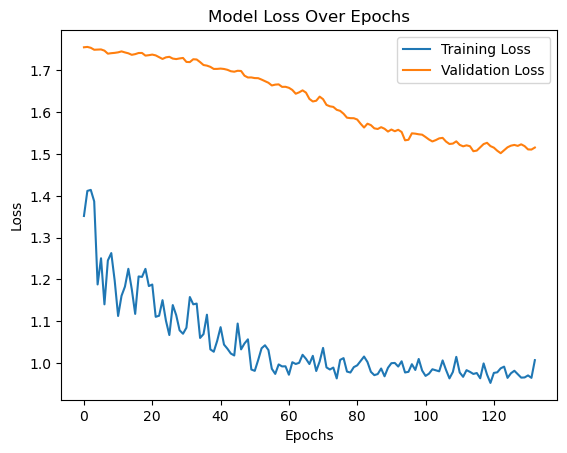

In [103]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Keras Tuner

In [24]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build LSTM model function with hyperparameter choices.
def build_lstm_model_tuner(hp):
    """
    Build an LSTM model for KerasTuner to optimize. Uses only residual sequences for input.
    """

    model = Sequential()

    # Define hyperparameters using `hp` for tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = hp.Choice("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size.

    # Add LSTM layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)  # Return sequences for intermediate layers only.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))
        model.add(BatchNormalization())  # Batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Dropout to combat overfitting.

    # Add the output layer (regression).
    model.add(Dense(1))

    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Print hyperparameters for debugging.
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")

    return model


# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_lstm_model_tuner,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of executions per trial.
    directory="sarimax-lstm",  # Directory to store tuning results.
    project_name="sarimax-lstm",  # Project name for the tuner.
    overwrite=True  # Overwrite previous tuner results if they exist.
)

# Define early stopping to prevent overfitting.
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Perform the hyperparameter search using the residuals (no features).
tuner.search(
    X_train_seq, y_train_seq,  # Training sequences and targets.
    validation_data=(X_test_seq, y_test_seq),  # Validation sequences and targets.
    epochs=200,  # Max number of epochs for each trial.
    callbacks=[early_stopping],  # Early stopping to avoid overfitting.
    shuffle=False,  # Ensure the time series order is preserved.
    verbose=1  # Show progress for each trial.
)

# Retrieve the best model and hyperparameters from the tuner.
best_lstm_model = tuner.get_best_models(num_models=1)[0]
best_lstm_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters found by KerasTuner.
print("Best hyperparameters for LSTM:", best_lstm_hyperparameters.values)
print("Best batch size for LSTM:", best_lstm_hyperparameters.get("batch_size"))

Trial 30 Complete [00h 00m 38s]
val_loss: 1.818834900856018

Best val_loss So Far: 1.7789051532745361
Total elapsed time: 00h 16m 32s
Built model with params: dropout_rate=0.4, recurrent_dropout=0.1, l2_lambda=0.0198938784755032, learning_rate=0.001, learning_rate_decay=1e-05, clipnorm=1.0, units=32, num_layers=1, batch_size=64
Best hyperparameters for LSTM: {'dropout_rate': 0.4, 'recurrent_dropout': 0.1, 'l2_lambda': 0.0198938784755032, 'learning_rate': 0.001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 1, 'batch_size': 64}
Best batch size for LSTM: 64


In [39]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.001,
    'l2_lambda': 0.0198938784755032,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.7582 - val_loss: 1.9223
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1917 - val_loss: 1.9171
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1810 - val_loss: 1.9164
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2196 - val_loss: 1.9034
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1189 - val_loss: 1.9032
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1282 - val_loss: 1.9012
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0796 - val_loss: 1.8996
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0239 - val_loss: 1.8890
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0846 - val_loss: 1.8900
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9874 - val_loss: 1.8916
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9655 - val_loss: 1.8810
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
LSTM Model Performance:
Training RMSE: 0.01334511202365849
Test RMSE: 0.018351929197169905
Training MAE: 0.009999517278217554
Test MAE: 0.014123623224008064
Directional Accuracy on Training Data: 66.47531572904707%
Directional Accuracy on Test Data: 68.66666666666667%


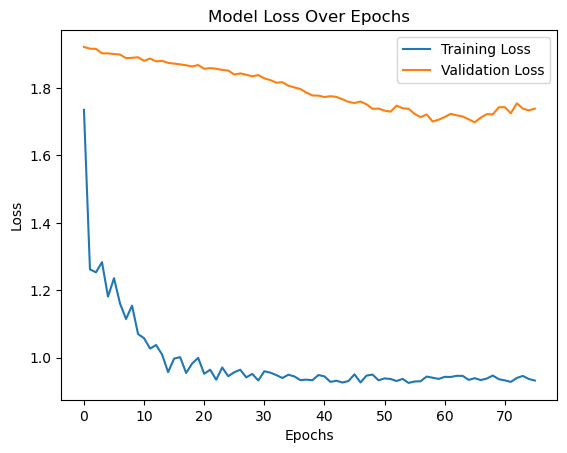

In [40]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Random Search with 2 Layers

In [28]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the LSTM model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.01, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 5.0, 'batch_size': 64}
Final Training Loss: 1.2432115077972412
Final Validation Loss: 1.9667257070541382
Running combination 2/30: {'units2': 128, 'units1': 64, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.001, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 1.525185227394104
Final Validation Loss: 2.244744300842285
Running combination 3/30: {'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 1.0, 'batch_size': 64}
Final Training Loss: 1.7460594177246094
Final Validation Loss: 2.0375723838806152
Running combination 4/

In [59]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 64,
    'units2': 32,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 1.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 2.2920 - val_loss: 2.0339
Epoch 2/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8627 - val_loss: 2.0238
Epoch 3/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6563 - val_loss: 2.0187
Epoch 4/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6945 - val_loss: 2.0281
Epoch 5/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5786 - val_loss: 2.0371
Epoch 6/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3790 - val_loss: 2.0088
Epoch 7/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3791 - val_loss: 2.0027
Epoch 8/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3329 - val_loss: 2.0272
Epoch 9/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2510 - val_loss: 2.0095
Epoch 10/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0929 - val_loss: 1.9583
Epoch 11/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1948 - val_loss: 1.9853
Epoch 12/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
LSTM Model Performance:
Training RMSE: 0.013233399739735745
Test RMSE: 0.01869615183967494
Training MAE: 0.009612968951848988
Test MAE: 0.014411496304505488
Directional Accuracy on Training Data: 65.44202066590127%
Directional Accuracy on Test Data: 68.66666666666667%


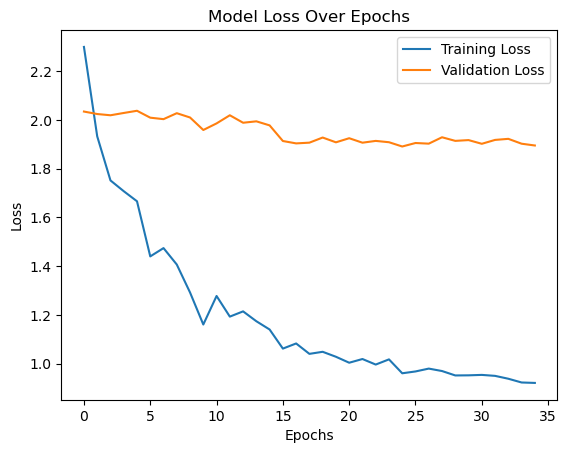

In [60]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Random Search with 3 Layers

In [32]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units3': 32, 'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 5.0, 'batch_size': 32}
Final Training Loss: 0.9471666216850281
Final Validation Loss: 1.9136559963226318
Running combination 2/30: {'units3': 128, 'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0001, 'l2_lambda': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 4.020496845245361
Final Validation Loss: 4.523107051849365
Running combination 3/30: {'units3': 128, 'units2': 64, 'units1': 64, 'recurrent_dropout': 0.1, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.4, 'clipnorm': 5.0, 'batch_size': 256}
Final Training Loss: 2.9050545692443848
Final Valida

In [84]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0005,
    'l2_lambda': 0.1,
    'epochs': 100,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))

        # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 12.6534 - val_loss: 11.3965
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.9634 - val_loss: 10.3921
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.8799 - val_loss: 9.4339
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.8630 - val_loss: 8.5328
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8355 - val_loss: 7.7375
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.9594 - val_loss: 7.0499
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.1988 - val_loss: 6.4512
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.6968 - val_loss: 5.9626
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3191 - val_loss: 5.5318
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7628 - val_loss: 5.1509
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3420 - val_loss: 4.8149
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
LSTM Model Performance:
Training RMSE: 0.013511579811636712
Test RMSE: 0.01831361762376318
Training MAE: 0.010048385199637347
Test MAE: 0.013946860005074146
Directional Accuracy on Training Data: 60.39035591274398%
Directional Accuracy on Test Data: 70.66666666666667%


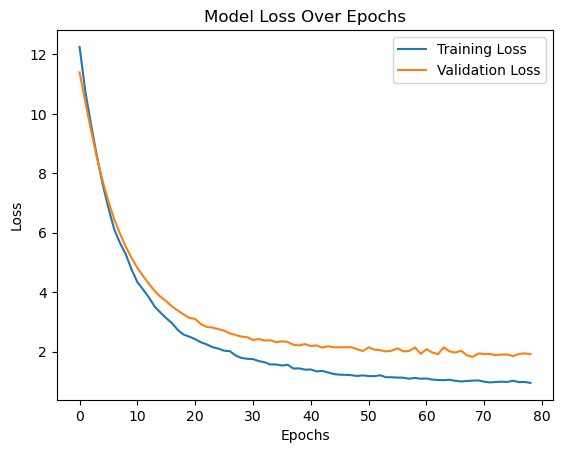

In [85]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model Performance Comparison (Sequence Length = 4)

### Residuals LSTM Model Performance Comparison for SL = 4

| **Metric**            | **Random Search (Optuna)** | **Keras Tuner**       | **Random Search (2 Layers)** | **Random Search (3 Layers)** |
|------------------------|---------------------------|-----------------------|------------------------------|------------------------------|
| **Train RMSE**         | 0.013280645              | 0.013345112           | 0.013233400                  | 0.013511580                  |
| **Test RMSE**          | 0.018085994              | 0.018351929           | 0.018696152                  | 0.018313618                  |
| **Train MAE**          | 0.009858145              | 0.009999517           | 0.009612969                  | 0.010048385                  |
| **Test MAE**           | 0.013953911              | 0.014123623           | 0.014411496                  | 0.013946860                  |
| **Train Loss**         | 1.006636500              | 0.931881487           | 0.920939922                  | 0.947166622                  |
| **Validation Loss**    | 1.515576720              | 1.739065647           | 1.894689560                  | 1.913655996                  |
| **Train DA**           | 56.95%                   | 66.48%                | 65.44%                       | 60.39%                       |
| **Test DA**            | 67.33%                   | 68.67%                | 68.67%                       | 70.67%                       |


The best model that have sequence length of 4 is with parameters from random search with 3 layers. Despite having the second lowest RMSE and the lowest MAE, the train and val loss plot shows that both curves decreases with more stability than Optuna (lowest RMSE). Also, had better DA. 
Therefore, **the best model for the current SL is the Random Search (3 Layers)**. 

### Cross Validation of the best model with SL of 4 with Descaled Metrics - Random Search (2 Layers).

#### Training and Validation Loss
| **Metric**           | **Loss**            |
|-----------------------|---------------------|
| **Training Loss**     | 0.01478191         |
| **Validation Loss**   | 0.02802864         |

- The gap between train and val loss is notable and this could indicate that there is a chance of overffiting. 

#### TSCV RMSE Values
| **Fold**   | **RMSE**         |
|------------|------------------|
| **Fold 1** | 0.02021290       |
| **Fold 2** | 0.01422077       |
| **Fold 3** | 0.01233996       |
| **Fold 4** | 0.01625720       |

**Average TSCV RMSE**: **0.01575771**

- The TSCV shows that the model performs above average in the first and last fold, a behaviour that was also observed in the residuals been scaled with standard scaler. 

#### FRWCV RMSE Values
| **Window**  | **RMSE**         |
|-------------|------------------|
| **Window 1** | 0.01753545       |
| **Window 2** | 0.01225658       |
| **Window 3** | 0.01276241       |
| **Window 4** | 0.01116210       |
| **Window 5** | 0.01376321       |

**Average FRWCV RMSE**: **0.01349595**

- Also shows stable performance across all windows part from the first where it scored above the average RMSE.

In [106]:
# Extract scaled train and validation loss from history
scaled_train_loss = history.history['loss'][-1]  # Final train loss
scaled_val_loss = history.history['val_loss'][-1]  # Final validation loss

# Retrieve the center (median) and scale (IQR) from the RobustScaler
center = scaler.center_[0]  # Median used by the RobustScaler
scale = scaler.scale_[0]    # IQR used by the RobustScaler

# Descale the train and validation losses
descaled_train_loss = scaled_train_loss * scale + center
descaled_val_loss = scaled_val_loss * scale + center

# Print the descaled losses
print(f"Descaled Training Loss: {descaled_train_loss}")
print(f"Descaled Validation Loss: {descaled_val_loss}")

Descaled Training Loss: 0.015597003872036315
Descaled Validation Loss: 0.022572553413985254


In [112]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 64,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.0005,
    'l2_lambda': 0.008803986788374445,
    'epochs': 150,
    'dropout_rate': 0.4,
    'clipnorm': 5.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    optimizer = Adam(learning_rate=params['learning_rate'], 
                     decay=params['learning_rate_decay'], 
                     clipnorm=params['clipnorm'])
    
    # Compile the model
    model.compile(optimizer=optimizer, loss=params['loss_function'])
    
    return model
# Define the number of splits for Time Series Cross-Validation
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize the list to store RMSE scores
tscv_rmse_scores = []

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Save the initial model weights to reset after each fold
model = build_best_model(best_params)

# Perform TSCV
for fold, (train_index, test_index) in enumerate(tscv.split(y_train_scaled)):
    print(f"Fold {fold + 1}")

    # Define train and test sets
    y_train_fold, y_test_fold = y_train_scaled[train_index], y_train_scaled[test_index]
    
    # Create sequences for TSCV
    X_train_seq, y_train_seq = [], []
    for i in range(len(y_train_fold) - sequence_length):
        X_train_seq.append(y_train_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_train_seq.append(y_train_fold[i + sequence_length])    # Next residual value as target.
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(y_test_fold) - sequence_length):
        X_test_seq.append(y_test_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_test_seq.append(y_test_fold[i + sequence_length])    # Next residual value as target.
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        verbose=0,
        callbacks=[early_stopping]
    )
    
    # Predict and evaluate
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    tscv_rmse_scores.append(rmse)
    print(f"Fold {fold + 1} RMSE: {rmse}")

# Calculate the average RMSE across all folds
avg_rmse = np.mean(tscv_rmse_scores)
print(f"Average RMSE from TSCV: {avg_rmse}")

Fold 1
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Fold 1 RMSE: 1.343414883965365
Fold 2
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold 2 RMSE: 0.9062259533599163
Fold 3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold 3 RMSE: 0.7690007854483705
Fold 4
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
Fold 4 RMSE: 1.054804994495623
Average RMSE from TSCV: 1.0183616543173186


In [113]:
# Parameters for FRWCV
train_window = 300  # Training window size
test_window = 100    # Test window size

# Store RMSEs for each window
rolling_rmse_scores = []

for start in range(0, len(y_train_scaled) - train_window - test_window, test_window):
    print(f"Rolling window starting at index {start}")
    
    # Define train and test sets for the window
    y_train_fold = y_train_scaled[start:start + train_window]
    y_test_fold = y_train_scaled[start + train_window:start + train_window + test_window]
    
    # Create sequences for FRWCV
    X_train_seq, y_train_seq = [], []
    for i in range(len(y_train_fold) - sequence_length):
        X_train_seq.append(y_train_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_train_seq.append(y_train_fold[i + sequence_length])    # Next residual value as target.
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(y_test_fold) - sequence_length):
        X_test_seq.append(y_test_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_test_seq.append(y_test_fold[i + sequence_length])    # Next residual value as target.
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=best_params['epochs'], 
        batch_size=best_params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        verbose=0,  # Suppress training logs for brevity
        callbacks=[early_stopping]
    )
    
    # Evaluate on the test set
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    rolling_rmse_scores.append(rmse)
    print(f"Rolling window RMSE: {rmse}")

# Calculate average RMSE across rolling windows
avg_rolling_rmse = np.mean(rolling_rmse_scores)
print(f"Average Rolling Window RMSE: {avg_rolling_rmse}")

Rolling window starting at index 0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
Rolling window RMSE: 1.1480663247628344
Rolling window starting at index 100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step
Rolling window RMSE: 0.7629170250383994
Rolling window starting at index 200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
Rolling window RMSE: 0.79982268949698
Rolling window starting at index 300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Rolling window RMSE: 0.6830635845830114
Rolling window starting at index 400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Rolling window RMSE: 0.8728416511903757
Average Rolling Window RMSE: 0.8533422550143202


In [114]:
# Function to descale RMSE
def descale_rmse(scaled_rmse, scaler):
    # Reshape RMSE value to fit scaler requirements
    scaled_rmse_array = np.array(scaled_rmse).reshape(-1, 1)
    # Inverse transform the RMSE
    descaled_rmse_array = scaler.inverse_transform(scaled_rmse_array)
    # Return the descaled RMSE as a list
    return descaled_rmse_array.flatten().tolist()

# Descale TSCV RMSE values
descaled_tscv_rmse = descale_rmse(tscv_rmse_scores, scaler)
print("Descaled TSCV RMSE Values:", descaled_tscv_rmse)

# Descale FRWCV RMSE values
descaled_frwcv_rmse = descale_rmse(rolling_rmse_scores, scaler)
print("Descaled FRWCV RMSE Values:", descaled_frwcv_rmse)

# Calculates average descaled RMSE
average_tscv_rmse = np.mean(descaled_tscv_rmse)
average_frwcv_rmse = np.mean(descaled_frwcv_rmse)
print(f"Average Descaled TSCV RMSE: {average_tscv_rmse}")
print(f"Average Descaled FRWCV RMSE: {average_frwcv_rmse}")

Descaled TSCV RMSE Values: [0.020212898249699043, 0.014220773977512162, 0.012339961811799369, 0.016257202661775893]
Descaled FRWCV RMSE Values: [0.01753544518263909, 0.01225657761364899, 0.012762407730338338, 0.011162104022774417, 0.013763207755368587]
Average Descaled TSCV RMSE: 0.015757709175196616
Average Descaled FRWCV RMSE: 0.013495948460953885


## Sequence Length = 12

In [72]:
# Reshape residual data into sequences for LSTM.
sequence_length = 12  # Number of time steps used for target prediction.

# Initialize empty lists for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the scaled training residuals to create sequences and targets.
for i in range(len(y_train_scaled) - sequence_length):
    X_train_seq.append(y_train_scaled[i:i + sequence_length])  # Sequence of past residuals.
    y_train_seq.append(y_train_scaled[i + sequence_length])    # Next residual value as target.

# Initialize empty lists for the test set.
X_test_seq, y_test_seq = [], []
# Loop through the scaled test residuals to create sequences and targets.
for i in range(len(y_test_scaled) - sequence_length):
    X_test_seq.append(y_test_scaled[i:i + sequence_length])  # Sequence of past residuals.
    y_test_seq.append(y_test_scaled[i + sequence_length])    # Next residual value as target.

# Convert lists to numpy arrays to use in LSTM model.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input and target data shapes for verification.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}")  
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}")  
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")    
print(f"Reshaped y_test_seq shape: {y_test_seq.shape}")    

Reshaped X_train_seq shape: (864, 12, 1)
Reshaped y_train_seq shape: (864, 1)
Reshaped X_test_seq shape: (143, 12, 1)
Reshaped y_test_seq shape: (143, 1)


### Random Search with Optuna

In [43]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def lstm_objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of a LSTM model.
    This version uses residuals only, without additional features.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.

    # Initialize the Sequential model.
    model = Sequential()

    # Add LSTM layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add LSTM layer with specified hyperparameters.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))

        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model with mean squared error loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(lstm_objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

[I 2024-12-02 20:14:59,189] A new study created in memory with name: no-name-03493604-7e15-448a-9898-b22e08e16391
[I 2024-12-02 20:15:36,427] Trial 0 finished with value: 2.281240224838257 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0037550037026405905, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 2.281240224838257.
[I 2024-12-02 20:16:08,500] Trial 1 finished with value: 4.174131393432617 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.04641587067816149, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 2, 'epochs': 50, 'batch_size': 256}. Best is trial 0 with value: 2.281240224838257.
[I 2024-12-02 20:17:36,877] Trial 2 finished with value: 4.143214225769043 and parameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2, '

Best hyperparameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.1, 'l2_lambda': 0.008178069238115187, 'learning_rate': 0.0005, 'learning_rate_decay': 1e-06, 'clipnorm': 5.0, 'units': 64, 'num_layers': 1, 'epochs': 200, 'batch_size': 120}
Best validation loss: 1.6277711391448975


In [125]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 64,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.0005,
    'l2_lambda': 0.008178069238115187,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 5.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))

    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 1.2565 - val_loss: 1.8472
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1753 - val_loss: 1.8430
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2331 - val_loss: 1.8448
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1716 - val_loss: 1.8400
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3142 - val_loss: 1.8374
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1632 - val_loss: 1.8358
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2527 - val_loss: 1.8330
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1982 - val_loss: 1.8330
Epoch 9/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1768 - val_loss: 1.8369
Epoch 10/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1166 - val_loss: 1.8401
Epoch 11/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1035 - val_loss: 1.8392
Epoch 12/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0957 - val_loss: 1.8352

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
LSTM Model Performance:
Training RMSE: 0.013395843737698717
Test RMSE: 0.019183192660779228
Training MAE: 0.009623019247566558
Test MAE: 0.015013432049529216
Directional Accuracy on Training Data: 68.59791425260718%
Directional Accuracy on Test Data: 67.6056338028169%


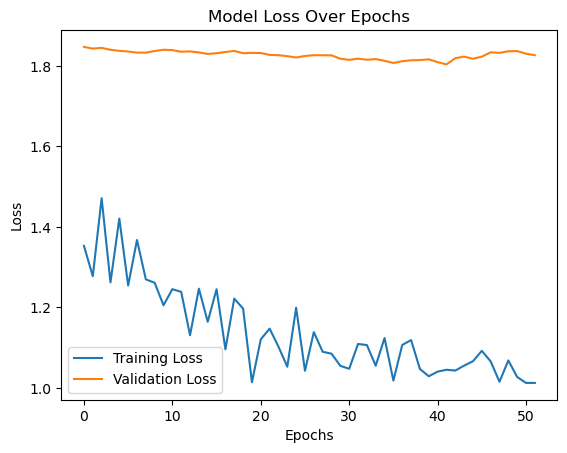

In [126]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Keras Tuner

In [47]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build LSTM model function with hyperparameter choices.
def build_lstm_model_tuner(hp):
    """
    Build an LSTM model for KerasTuner to optimize. Uses only residual sequences for input.
    """

    model = Sequential()

    # Define hyperparameters using `hp` for tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = hp.Choice("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size.

    # Add LSTM layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)  # Return sequences for intermediate layers only.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))
        model.add(BatchNormalization())  # Batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Dropout to combat overfitting.

    # Add the output layer (regression).
    model.add(Dense(1))

    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Print hyperparameters for debugging.
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")

    return model


# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_lstm_model_tuner,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of executions per trial.
    directory="sarimax-lstm",  # Directory to store tuning results.
    project_name="sarimax-lstm",  # Project name for the tuner.
    overwrite=True  # Overwrite previous tuner results if they exist.
)

# Define early stopping to prevent overfitting.
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Perform the hyperparameter search using the residuals (no features).
tuner.search(
    X_train_seq, y_train_seq,  # Training sequences and targets.
    validation_data=(X_test_seq, y_test_seq),  # Validation sequences and targets.
    epochs=200,  # Max number of epochs for each trial.
    callbacks=[early_stopping],  # Early stopping to avoid overfitting.
    shuffle=False,  # Ensure the time series order is preserved.
    verbose=1  # Show progress for each trial.
)

# Retrieve the best model and hyperparameters from the tuner.
best_lstm_model = tuner.get_best_models(num_models=1)[0]
best_lstm_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters found by KerasTuner.
print("Best hyperparameters for LSTM:", best_lstm_hyperparameters.values)
print("Best batch size for LSTM:", best_lstm_hyperparameters.get("batch_size"))

Trial 30 Complete [00h 01m 01s]
val_loss: 1.7321281433105469

Best val_loss So Far: 1.7321281433105469
Total elapsed time: 00h 20m 37s
Built model with params: dropout_rate=0.4, recurrent_dropout=0.2, l2_lambda=0.0960392293213717, learning_rate=0.001, learning_rate_decay=1e-05, clipnorm=1.0, units=128, num_layers=2, batch_size=32
Best hyperparameters for LSTM: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0960392293213717, 'learning_rate': 0.001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 128, 'num_layers': 2, 'batch_size': 32}
Best batch size for LSTM: 32


In [74]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'units2': 128,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.001,
    'l2_lambda': 0.0960392293213717,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))

    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 21.2705 - val_loss: 14.9172
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 13.7985 - val_loss: 10.0805
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 9.2461 - val_loss: 6.9740
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 6.2316 - val_loss: 5.2877
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 4.6677 - val_loss: 4.3341
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 3.7582 - val_loss: 3.7054
Epoch 7/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 2.9133 - val_loss: 3.2070
Epoch 8/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 2.4949 - val_loss: 2.9055
Epoch 9/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 2.1321 - val_loss: 2.6781
Epoch 10/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.8953 - val_loss: 2.5072
Epoch 11/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.6063 - val_loss: 2.3375
Epoch 12/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step
LSTM Model Performance:
Training RMSE: 0.015134037567878946
Test RMSE: 0.017709847457086043
Training MAE: 0.010599869151276158
Test MAE: 0.01340479060547334
Directional Accuracy on Training Data: 69.98841251448435%
Directional Accuracy on Test Data: 71.12676056338029%


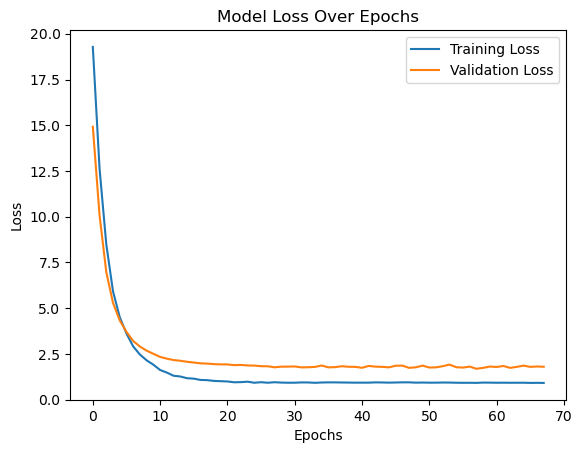

In [75]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Random Search with 2 Layers

In [51]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the LSTM model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.01, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 5.0, 'batch_size': 64}
Final Training Loss: 1.3370949029922485
Final Validation Loss: 2.15482234954834
Running combination 2/30: {'units2': 128, 'units1': 64, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.001, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 1.5595332384109497
Final Validation Loss: 2.388045310974121
Running combination 3/30: {'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 1.0, 'batch_size': 64}
Final Training Loss: 1.7163903713226318
Final Validation Loss: 2.1590282917022705
Running combination 4/3

In [157]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 64,
    'units2': 32,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 1.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 2.4267 - val_loss: 2.0670
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0014 - val_loss: 2.0609
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6594 - val_loss: 2.0778
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6047 - val_loss: 2.0666
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5751 - val_loss: 2.0725
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4089 - val_loss: 2.0621
Epoch 7/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3568 - val_loss: 2.0636
Epoch 8/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2905 - val_loss: 2.0364
Epoch 9/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2583 - val_loss: 2.0319
Epoch 10/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1334 - val_loss: 2.0413
Epoch 11/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1208 - val_loss: 2.0035
Epoch 12/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
LSTM Model Performance:
Training RMSE: 0.013413274105610763
Test RMSE: 0.018647866989473762
Training MAE: 0.009881110135033797
Test MAE: 0.014413452824369233
Directional Accuracy on Training Data: 58.16917728852838%
Directional Accuracy on Test Data: 68.30985915492957%


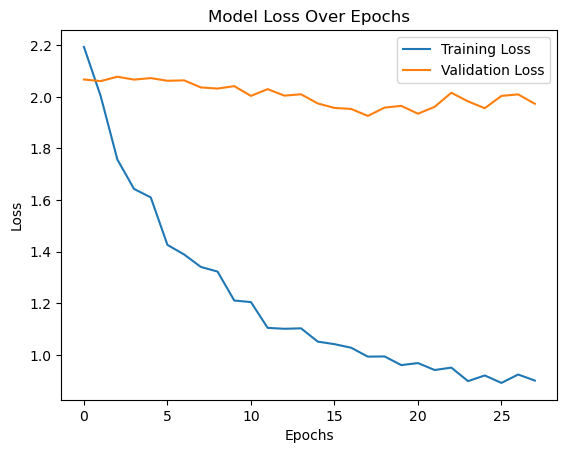

In [158]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Random Search with 3 Layers

In [55]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units3': 32, 'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 5.0, 'batch_size': 32}
Final Training Loss: 0.961948812007904
Final Validation Loss: 1.8994677066802979
Running combination 2/30: {'units3': 128, 'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0001, 'l2_lambda': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 3.948814630508423
Final Validation Loss: 4.547524452209473
Running combination 3/30: {'units3': 128, 'units2': 64, 'units1': 64, 'recurrent_dropout': 0.1, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.4, 'clipnorm': 5.0, 'batch_size': 256}
Final Training Loss: 2.8360342979431152
Final Validat

In [173]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0005,
    'l2_lambda': 0.1,
    'epochs': 100,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))

        # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 12.3658 - val_loss: 11.4683
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.9202 - val_loss: 10.4668
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.7631 - val_loss: 9.5388
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.7876 - val_loss: 8.7140
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.8669 - val_loss: 7.9647
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.2464 - val_loss: 7.2988
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.5215 - val_loss: 6.7269
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.8922 - val_loss: 6.2386
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.5416 - val_loss: 5.7914
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9915 - val_loss: 5.4017
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5344 - val_loss: 5.0406
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
LSTM Model Performance:
Training RMSE: 0.014787134947450804
Test RMSE: 0.018404273487324846
Training MAE: 0.010986247407459042
Test MAE: 0.01400456098947821
Directional Accuracy on Training Data: 58.63267670915412%
Directional Accuracy on Test Data: 66.19718309859155%


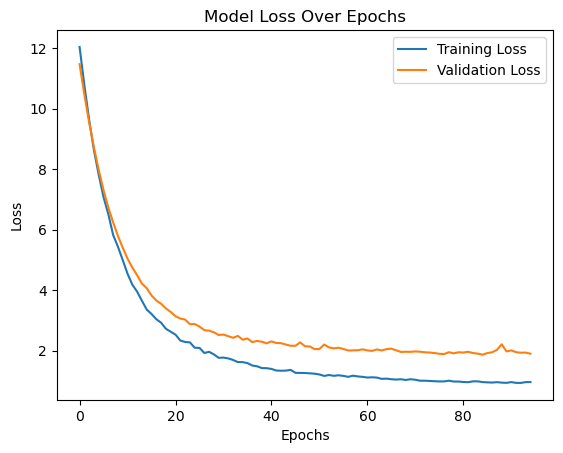

In [174]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [76]:
# Extract scaled train and validation loss from history
scaled_train_loss = history.history['loss'][-1]  # Final train loss
scaled_val_loss = history.history['val_loss'][-1]  # Final validation loss

# Retrieve the center (median) and scale (IQR) from the RobustScaler
center = scaler.center_[0]  # Median used by the RobustScaler
scale = scaler.scale_[0]    # IQR used by the RobustScaler

# Descale the train and validation losses
descaled_train_loss = scaled_train_loss * scale + center
descaled_val_loss = scaled_val_loss * scale + center

# Print the descaled losses
print(f"Descaled Training Loss: {descaled_train_loss}")
print(f"Descaled Validation Loss: {descaled_val_loss}")

Descaled Training Loss: 0.01436210955800261
Descaled Validation Loss: 0.026481308718719447


### Residuals LSTM Model Performance Comparison for SL = 12

| **Metric**            | **Random Search (Optuna)** | **Keras Tuner**       | **Random Search (2 Layers)** | **Random Search (3 Layers)** |
|------------------------|---------------------------|-----------------------|-----------------------------|-----------------------------|
| **Train RMSE**         | 0.013395844              | 0.015134038           | 0.013413274                  | 0.014787135                 |
| **Test RMSE**          | 0.019183193              | 0.017709847           | 0.018647867                  | 0.018404273                 |
| **Train MAE**          | 0.009623019              | 0.010599869           | 0.009881110                  | 0.010986247                 |
| **Test MAE**           | 0.015013432              | 0.013404791           | 0.014413453                  | 0.014004561                 |
| **Train Loss**         | 1.012394547              | 0.916537881           | 0.900741518                  | 0.961948812                 |
| **Validation Loss**    | 1.826569796              | 1.800761819           | 1.972934008                  | 1.899467707                 |
| **Train DA**           | 68.60%                   | 69.99%                | 58.17%                       | 58.63%                      |
| **Test DA**            | 67.61%                   | 71.13%                | 68.31%                       | 66.20%                      |

**BEST MODEL**: **Keras Tuner**


- The model that presented the lowest metrics for both RMSE and MAE is the parameters obtained from Keras Tuner.

### Cross-Validation Results for Random Search (Keras) Model (Sequence Length = 12)

#### **Training and Validation Loss**
| **Metric**           | **Loss**          |
|-----------------------|-------------------|
| **Training Loss**     | 0.01436211        |
| **Validation Loss**   | 0.02648131        |

- The gap between shows that the model can potentially overfit. Although, the gap is smaller if compared with SL = 4. 

#### **TSCV RMSE Values**
| **Fold** | **RMSE**         |
|----------|------------------|
| **1**    | 0.02023338       |
| **2**    | 0.01418727       |
| **3**    | 0.01271732       |
| **4**    | 0.01650192       |

**Average TSCV RMSE**: **0.0159100**

- The model shows improvements throughout the folds, similary to the sequence length of 4. 

#### **FRWCV RMSE Values**
| **Window** | **RMSE**       |
|------------|----------------|
| Window 1   | 0.01809409     |
| Window 2   | 0.01245716     |
| Window 3   | 0.01344320     |
| Window 4   | 0.01129898     |
| Window 5   | 0.01449306     |

**Average FRWCV RMSE**: **0.01395730**

- The model performs better when data is increased as shown in the performance on both cross-validation. 

In [184]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'units2': 128,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.001,
    'l2_lambda': 0.0960392293213717,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    optimizer = Adam(learning_rate=params['learning_rate'], 
                     decay=params['learning_rate_decay'], 
                     clipnorm=params['clipnorm'])
    
    # Compile the model
    model.compile(optimizer=optimizer, loss=params['loss_function'])
    
    return model

# Define the number of splits for Time Series Cross-Validation
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize the list to store RMSE scores
tscv_rmse_scores = []

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create the model once and save its initial weights
model = build_best_model(best_params)
initial_weights = model.get_weights()

# Perform TSCV
for fold, (train_index, test_index) in enumerate(tscv.split(y_train_scaled)):
    print(f"Fold {fold + 1}")

    # Reset model to initial weights
    model.set_weights(initial_weights)
    
    # Define train and test sets
    y_train_fold, y_test_fold = y_train_scaled[train_index], y_train_scaled[test_index]
    
    # Create sequences for TSCV
    X_train_seq, y_train_seq = [], []
    for i in range(len(y_train_fold) - sequence_length):
        X_train_seq.append(y_train_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_train_seq.append(y_train_fold[i + sequence_length])    # Next residual value as target.
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(y_test_fold) - sequence_length):
        X_test_seq.append(y_test_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_test_seq.append(y_test_fold[i + sequence_length])    # Next residual value as target.
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        verbose=0,
        callbacks=[early_stopping]
    )
    
    # Predict and evaluate
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    tscv_rmse_scores.append(rmse)
    print(f"Fold {fold + 1} RMSE: {rmse}")

# Calculate the average RMSE across all folds
avg_rmse = np.mean(tscv_rmse_scores)
print(f"Average RMSE from TSCV: {avg_rmse}")

Fold 1
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Fold 1 RMSE: 1.344909270140416
Fold 2
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Fold 2 RMSE: 0.9037815648961878
Fold 3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Fold 3 RMSE: 0.7965327649927788
Fold 4
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold 4 RMSE: 1.0726596682044995
Average RMSE from TSCV: 1.0294708170584705


In [185]:
# Parameters for FRWCV
train_window = 300  # Training window size
test_window = 100    # Test window size

# Store RMSEs for each window
rolling_rmse_scores = []

for start in range(0, len(y_train_scaled) - train_window - test_window, test_window):
    print(f"Rolling window starting at index {start}")
    
    # Define train and test sets for the window
    y_train_fold = y_train_scaled[start:start + train_window]
    y_test_fold = y_train_scaled[start + train_window:start + train_window + test_window]
    
    # Create sequences for FRWCV
    X_train_seq, y_train_seq = [], []
    for i in range(len(y_train_fold) - sequence_length):
        X_train_seq.append(y_train_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_train_seq.append(y_train_fold[i + sequence_length])    # Next residual value as target.
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(y_test_fold) - sequence_length):
        X_test_seq.append(y_test_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_test_seq.append(y_test_fold[i + sequence_length])    # Next residual value as target.
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    model.set_weights(initial_weights)  # Reset to initial weights
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=best_params['epochs'], 
        batch_size=best_params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        verbose=0,  # Suppress training logs for brevity
        callbacks=[early_stopping]
    )
    
    # Evaluate on the test set
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    rolling_rmse_scores.append(rmse)
    print(f"Rolling window RMSE: {rmse}")

# Calculate average RMSE across rolling windows
avg_rolling_rmse = np.mean(rolling_rmse_scores)
print(f"Average Rolling Window RMSE: {avg_rolling_rmse}")

Rolling window starting at index 0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Rolling window RMSE: 1.1888254344194173
Rolling window starting at index 100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Rolling window RMSE: 0.777551702330344
Rolling window starting at index 200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Rolling window RMSE: 0.8494935898355374
Rolling window starting at index 300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Rolling window RMSE: 0.6930503278231804
Rolling window starting at index 400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Rolling window RMSE: 0.9260922461883013
Average Rolling Window RMSE: 0.8870026601193561


In [186]:
# Function to descale RMSE
def descale_rmse(scaled_rmse, scaler):
    # Reshape RMSE value to fit scaler requirements
    scaled_rmse_array = np.array(scaled_rmse).reshape(-1, 1)
    # Inverse transform the RMSE
    descaled_rmse_array = scaler.inverse_transform(scaled_rmse_array)
    # Return the descaled RMSE as a list
    return descaled_rmse_array.flatten().tolist()

# Descale TSCV RMSE values
descaled_tscv_rmse = descale_rmse(tscv_rmse_scores, scaler)
print("Descaled TSCV RMSE Values:", descaled_tscv_rmse)

# Descale FRWCV RMSE values
descaled_frwcv_rmse = descale_rmse(rolling_rmse_scores, scaler)
print("Descaled FRWCV RMSE Values:", descaled_frwcv_rmse)

# Calculates average descaled RMSE
average_tscv_rmse = np.mean(descaled_tscv_rmse)
average_frwcv_rmse = np.mean(descaled_frwcv_rmse)
print(f"Average Descaled TSCV RMSE: {average_tscv_rmse}")
print(f"Average Descaled FRWCV RMSE: {average_frwcv_rmse}")

Descaled TSCV RMSE Values: [0.020233380350330323, 0.014187271117721369, 0.012717315928841934, 0.01650191934194154]
Descaled FRWCV RMSE Values: [0.018094090731939037, 0.012457160928727989, 0.01344319854342654, 0.011298982617771418, 0.014493061968176705]
Average Descaled TSCV RMSE: 0.01590997168470879
Average Descaled FRWCV RMSE: 0.013957298958008338


## Sequence Length = 26

In [33]:
# Reshape residual data into sequences for LSTM.
sequence_length = 26  # Number of time steps used for target prediction.

# Initialize empty lists for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the scaled training residuals to create sequences and targets.
for i in range(len(y_train_scaled) - sequence_length):
    X_train_seq.append(y_train_scaled[i:i + sequence_length])  # Sequence of past residuals.
    y_train_seq.append(y_train_scaled[i + sequence_length])    # Next residual value as target.

# Initialize empty lists for the test set.
X_test_seq, y_test_seq = [], []
# Loop through the scaled test residuals to create sequences and targets.
for i in range(len(y_test_scaled) - sequence_length):
    X_test_seq.append(y_test_scaled[i:i + sequence_length])  # Sequence of past residuals.
    y_test_seq.append(y_test_scaled[i + sequence_length])    # Next residual value as target.

# Convert lists to numpy arrays to use in LSTM model.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input and target data shapes for verification.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}") 
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}") 
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")    
print(f"Reshaped y_test_seq shape: {y_test_seq.shape}")    

Reshaped X_train_seq shape: (850, 26, 1)
Reshaped y_train_seq shape: (850, 1)
Reshaped X_test_seq shape: (129, 26, 1)
Reshaped y_test_seq shape: (129, 1)


### Random Search with Optuna

In [66]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def lstm_objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of a LSTM model.
    This version uses residuals only, without additional features.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.

    # Initialize the Sequential model.
    model = Sequential()

    # Add LSTM layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add LSTM layer with specified hyperparameters.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))

        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model with mean squared error loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(lstm_objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

[I 2024-12-02 21:17:09,372] A new study created in memory with name: no-name-4847968d-4f01-4f35-8670-6280417034d0
[I 2024-12-02 21:18:07,726] Trial 0 finished with value: 1.922869324684143 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0037550037026405905, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 1.922869324684143.
[I 2024-12-02 21:18:38,136] Trial 1 finished with value: 4.263016700744629 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.04641587067816149, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 2, 'epochs': 50, 'batch_size': 256}. Best is trial 0 with value: 1.922869324684143.
[I 2024-12-02 21:20:44,378] Trial 2 finished with value: 4.680333137512207 and parameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2, '

Best hyperparameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.1, 'l2_lambda': 0.00226945148560162, 'learning_rate': 0.001, 'learning_rate_decay': 0, 'clipnorm': 5.0, 'units': 128, 'num_layers': 1, 'epochs': 200, 'batch_size': 64}
Best validation loss: 1.3345979452133179


In [195]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.001,
    'l2_lambda': 0.00226945148560162,
    'epochs': 200,
    'dropout_rate': 0.30000000000000004,
    'clipnorm': 5.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1.1162 - val_loss: 1.6940
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0948 - val_loss: 1.6852
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1413 - val_loss: 1.7025
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1572 - val_loss: 1.7150
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9788 - val_loss: 1.7093
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9688 - val_loss: 1.6904
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0491 - val_loss: 1.6941
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.9770 - val_loss: 1.6793
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9415 - val_loss: 1.6800
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0011 - val_loss: 1.6965
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9484 - val_loss: 1.6807
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
LSTM Model Performance:
Training RMSE: 0.017173040919470563
Test RMSE: 0.019582171589503473
Training MAE: 0.014906502647430311
Test MAE: 0.015274209606368869
Directional Accuracy on Training Data: 66.19552414605418%
Directional Accuracy on Test Data: 71.875%


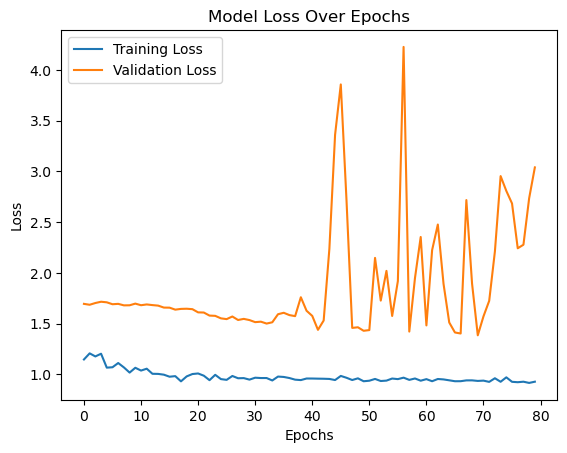

In [196]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Keras Tuner

In [70]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build LSTM model function with hyperparameter choices.
def build_lstm_model_tuner(hp):
    """
    Build an LSTM model for KerasTuner to optimize. Uses only residual sequences for input.
    """

    model = Sequential()

    # Define hyperparameters using `hp` for tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = hp.Choice("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size.

    # Add LSTM layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)  # Return sequences for intermediate layers only.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))
        model.add(BatchNormalization())  # Batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Dropout to combat overfitting.

    # Add the output layer (regression).
    model.add(Dense(1))

    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Print hyperparameters for debugging.
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")

    return model


# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_lstm_model_tuner,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of executions per trial.
    directory="sarimax-lstm",  # Directory to store tuning results.
    project_name="sarimax-lstm",  # Project name for the tuner.
    overwrite=True  # Overwrite previous tuner results if they exist.
)

# Define early stopping to prevent overfitting.
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Perform the hyperparameter search using the residuals (no features).
tuner.search(
    X_train_seq, y_train_seq,  # Training sequences and targets.
    validation_data=(X_test_seq, y_test_seq),  # Validation sequences and targets.
    epochs=200,  # Max number of epochs for each trial.
    callbacks=[early_stopping],  # Early stopping to avoid overfitting.
    shuffle=False,  # Ensure the time series order is preserved.
    verbose=1  # Show progress for each trial.
)

# Retrieve the best model and hyperparameters from the tuner.
best_lstm_model = tuner.get_best_models(num_models=1)[0]
best_lstm_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters found by KerasTuner.
print("Best hyperparameters for LSTM:", best_lstm_hyperparameters.values)
print("Best batch size for LSTM:", best_lstm_hyperparameters.get("batch_size"))

Trial 30 Complete [00h 00m 54s]
val_loss: 1.5448733568191528

Best val_loss So Far: 1.5448733568191528
Total elapsed time: 00h 27m 04s
Built model with params: dropout_rate=0.4, recurrent_dropout=0.2, l2_lambda=0.0960392293213717, learning_rate=0.001, learning_rate_decay=1e-05, clipnorm=1.0, units=128, num_layers=2, batch_size=32
Best hyperparameters for LSTM: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0960392293213717, 'learning_rate': 0.001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 128, 'num_layers': 2, 'batch_size': 32}
Best batch size for LSTM: 32


In [197]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'units2': 128,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.001,
    'l2_lambda': 0.0960392293213717,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 20.8493 - val_loss: 15.0279
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 14.3610 - val_loss: 10.3021
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.5347 - val_loss: 7.1372
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.6845 - val_loss: 5.5199
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.2296 - val_loss: 4.4669
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.9519 - val_loss: 3.7261
Epoch 7/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.3302 - val_loss: 3.2384
Epoch 8/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.8419 - val_loss: 2.8950
Epoch 9/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.2319 - val_loss: 2.6192
Epoch 10/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.0725 - val_loss: 2.4300
Epoch 11/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.7792 - val_loss: 2.2888
Epoch 12/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
LSTM Model Performance:
Training RMSE: 0.015522640904793446
Test RMSE: 0.018242964682965577
Training MAE: 0.010974200751220744
Test MAE: 0.014089160854113884
Directional Accuracy on Training Data: 65.60659599528857%
Directional Accuracy on Test Data: 71.09375%


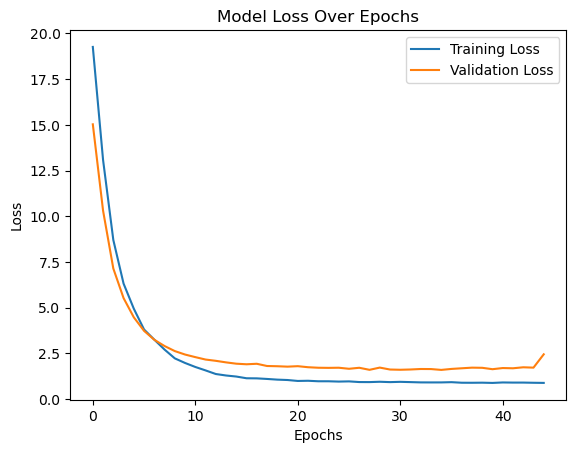

In [199]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Random Search with 2 Layers

In [74]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the LSTM model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.01, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 5.0, 'batch_size': 64}
Final Training Loss: 1.3456990718841553
Final Validation Loss: 2.0248262882232666
Running combination 2/30: {'units2': 128, 'units1': 64, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.001, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 1.5918534994125366
Final Validation Loss: 2.310624361038208
Running combination 3/30: {'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 1.0, 'batch_size': 64}
Final Training Loss: 1.08603835105896
Final Validation Loss: 2.036924123764038
Running combination 4/30

In [219]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 64,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.0001,
    'l2_lambda': 0.001,
    'epochs': 100,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 4.4148 - val_loss: 1.9561
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 3.3714 - val_loss: 1.9476
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 2.9047 - val_loss: 1.9340
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 2.6394 - val_loss: 1.9196
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 2.8120 - val_loss: 1.9129
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.3220 - val_loss: 1.8913
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2.4800 - val_loss: 1.8736
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2.4446 - val_loss: 1.8730
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2.0940 - val_loss: 1.8666
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 2.3452 - val_loss: 1.8565
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.1843 - val_loss: 1.8456
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/ste

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
LSTM Model Performance:
Training RMSE: 0.014972837987734147
Test RMSE: 0.018735295343625155
Training MAE: 0.010946054081981975
Test MAE: 0.01422049473558096
Directional Accuracy on Training Data: 69.96466431095406%
Directional Accuracy on Test Data: 74.21875%


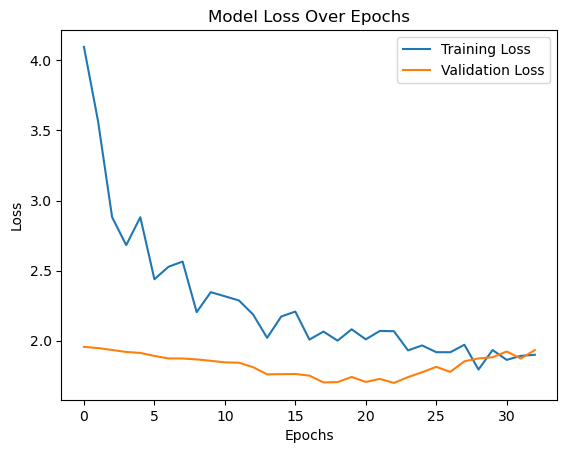

In [220]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Random Search with 3 Layers

In [78]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units3': 32, 'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 5.0, 'batch_size': 32}
Final Training Loss: 0.9136958718299866
Final Validation Loss: 1.6999963521957397
Running combination 2/30: {'units3': 128, 'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0001, 'l2_lambda': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 3.987945795059204
Final Validation Loss: 4.459192276000977
Running combination 3/30: {'units3': 128, 'units2': 64, 'units1': 64, 'recurrent_dropout': 0.1, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.4, 'clipnorm': 5.0, 'batch_size': 256}
Final Training Loss: 2.7583069801330566
Final Valida

In [37]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0005,
    'l2_lambda': 0.1,
    'epochs': 100,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))

        # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - loss: 12.4379 - val_loss: 11.3835
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 10.9729 - val_loss: 10.4346
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 9.7779 - val_loss: 9.5165
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 8.8732 - val_loss: 8.6740
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 8.0195 - val_loss: 7.9218
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 7.1958 - val_loss: 7.2693
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 6.5383 - val_loss: 6.6881
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 6.0017 - val_loss: 6.1740
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 5.5824 - val_loss: 5.7343
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 5.0446 - val_loss: 5.3664
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 4.5489 - val_loss: 5.0170
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
LSTM Model Performance:
Training RMSE: 0.018747995012072104
Test RMSE: 0.018065793008686847
Training MAE: 0.012678031335398271
Test MAE: 0.013946645607206367
Directional Accuracy on Training Data: 63.25088339222616%
Directional Accuracy on Test Data: 72.65625%


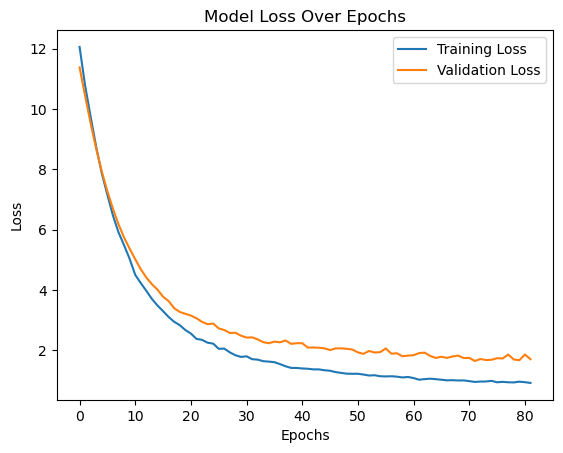

In [38]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [39]:
# Extract scaled train and validation loss from history
scaled_train_loss = history.history['loss'][-1]  # Final train loss
scaled_val_loss = history.history['val_loss'][-1]  # Final validation loss

# Retrieve the center (median) and scale (IQR) from the RobustScaler
center = scaler.center_[0]  # Median used by the RobustScaler
scale = scaler.scale_[0]    # IQR used by the RobustScaler

# Descale the train and validation losses
descaled_train_loss = scaled_train_loss * scale + center
descaled_val_loss = scaled_val_loss * scale + center

# Print the descaled losses
print(f"Descaled Training Loss: {descaled_train_loss}")
print(f"Descaled Validation Loss: {descaled_val_loss}")

Descaled Training Loss: 0.014323156898584244
Descaled Validation Loss: 0.025100214284522346


### Model Performance Comparison (SL = 26)

| **Metric**            | **Random Search (Optuna)** | **Keras Tuner**       | **Random Search (2 Layers)** | **Random Search (3 Layers)** |
|------------------------|---------------------------|-----------------------|------------------------------|------------------------------|
| **Train RMSE**         | 0.017173041              | 0.015522641           | 0.014972838                  | 0.018747995                 |
| **Test RMSE**          | 0.019582172              | 0.018242965           | 0.018735295                  | 0.018065793                 |
| **Train MAE**          | 0.014906503              | 0.010974201           | 0.010946054                  | 0.012678031                 |
| **Test MAE**           | 0.015274210              | 0.014089161           | 0.014220495                  | 0.013946646                 |
| **Train Loss**         | 0.927378476              | 0.878159404           | 1.899828196                  | 0.913695872                 |
| **Validation Loss**    | 3.038491488              | 2.442846775           | 1.933014274                  | 1.699996352                 |
| **Train DA**           | 66.20%                   | 65.61%                | 69.96%                       | 63.25%                      |
| **Test DA**            | 71.88%                   | 71.09%                | 74.22%                       | 72.66%                      |


According to the score metric table, the model from Random Search with 3 layers shows:
- Lowest TEST (RMSE and MAE), showing better performance on unseen data.  
- Lowest validation loss among the models.  
- Highest DA, menaing that despite not getting the right value, the direction of the prediction is more accurate than the others. 
- The train and val loss plot shows that the both losses decreases steadily. 

### Cross-Validation Results for SL = 26 (Best Model)

#### **Training and Validation Loss**
| **Metric**           | **Loss**         |
|-----------------------|------------------|
| **Training Loss**     | 0.01432316       |
| **Validation Loss**   | 0.02510021       |

#### **TSCV RMSE Values**
| **Fold** | **RMSE**         |
|----------|------------------|
| **1**    | 0.02094209       |
| **2**    | 0.01428537       |
| **3**    | 0.01228780       |
| **4**    | 0.01702989       |

**Average TSCV RMSE**: **0.01474769**

- The model with a higher sequence length performs similar to previous SL, however it has registered higher erros according to the scores. 

#### **FRWCV RMSE Values**
| **Window** | **RMSE**         |
|------------|------------------|
| **1**      | 0.01714008       |
| **2**      | 0.01244101       |
| **3**      | 0.01344710       |
| **4**      | 0.00921653       |
| **5**      | 0.01474769       |

**Average FRWCV RMSE**: **0.01339848**

- The FRWCV scores start to decrease and the hypothesis of longer sequences helps the model to perform better throughout the windows can be considered.

In [50]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0005,
    'l2_lambda': 0.1,
    'epochs': 100,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))

        # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    optimizer = Adam(learning_rate=params['learning_rate'], 
                     decay=params['learning_rate_decay'], 
                     clipnorm=params['clipnorm'])
    
    # Compile the model
    model.compile(optimizer=optimizer, loss=params['loss_function'])
    
    return model

# Define the number of splits for Time Series Cross-Validation
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize the list to store RMSE scores
tscv_rmse_scores = []

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create the model once and save its initial weights
model = build_best_model(best_params)
initial_weights = model.get_weights()

# Perform TSCV
for fold, (train_index, test_index) in enumerate(tscv.split(y_train_scaled)):
    print(f"Fold {fold + 1}")

    # Reset model to initial weights
    model.set_weights(initial_weights)
    
    # Define train and test sets
    y_train_fold, y_test_fold = y_train_scaled[train_index], y_train_scaled[test_index]
    
    # Create sequences for TSCV
    X_train_seq, y_train_seq = [], []
    for i in range(len(y_train_fold) - sequence_length):
        X_train_seq.append(y_train_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_train_seq.append(y_train_fold[i + sequence_length])    # Next residual value as target.
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(y_test_fold) - sequence_length):
        X_test_seq.append(y_test_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_test_seq.append(y_test_fold[i + sequence_length])    # Next residual value as target.
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        verbose=0,
        callbacks=[early_stopping]
    )
    
    # Predict and evaluate
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    tscv_rmse_scores.append(rmse)
    print(f"Fold {fold + 1} RMSE: {rmse}")

# Calculate the average RMSE across all folds
avg_rmse = np.mean(tscv_rmse_scores)
print(f"Average RMSE from TSCV: {avg_rmse}")

Fold 1
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step
Fold 1 RMSE: 1.3966173035274085
Fold 2
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Fold 2 RMSE: 0.9109390133586703
Fold 3
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Fold 3 RMSE: 0.7651949372928015
Fold 4
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Fold 4 RMSE: 1.111180844357207
Average RMSE from TSCV: 1.045983024634022


In [41]:
# Parameters for FRWCV
train_window = 300  # Training window size
test_window = 100    # Test window size

# Store RMSEs for each window
rolling_rmse_scores = []

for start in range(0, len(y_train_scaled) - train_window - test_window, test_window):
    print(f"Rolling window starting at index {start}")
    
    # Define train and test sets for the window
    y_train_fold = y_train_scaled[start:start + train_window]
    y_test_fold = y_train_scaled[start + train_window:start + train_window + test_window]
    
    # Create sequences for FRWCV
    X_train_seq, y_train_seq = [], []
    for i in range(len(y_train_fold) - sequence_length):
        X_train_seq.append(y_train_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_train_seq.append(y_train_fold[i + sequence_length])    # Next residual value as target.
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(y_test_fold) - sequence_length):
        X_test_seq.append(y_test_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_test_seq.append(y_test_fold[i + sequence_length])    # Next residual value as target.
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    model.set_weights(initial_weights)  # Reset to initial weights
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=best_params['epochs'], 
        batch_size=best_params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        verbose=0,  # Suppress training logs for brevity
        callbacks=[early_stopping]
    )
    
    # Evaluate on the test set
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    rolling_rmse_scores.append(rmse)
    print(f"Rolling window RMSE: {rmse}")

# Calculate average RMSE across rolling windows
avg_rolling_rmse = np.mean(rolling_rmse_scores)
print(f"Average Rolling Window RMSE: {avg_rolling_rmse}")

Rolling window starting at index 0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Rolling window RMSE: 1.1192204493787166
Rolling window starting at index 100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Rolling window RMSE: 0.7763730229164044
Rolling window starting at index 200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Rolling window RMSE: 0.8497781217042306
Rolling window starting at index 300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Rolling window RMSE: 0.5411131673724909
Rolling window starting at index 400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Rolling window RMSE: 0.944669941033968
Average Rolling Window RMSE: 0.8462309404811622


In [42]:
# Function to descale RMSE
def descale_rmse(scaled_rmse, scaler):
    # Reshape RMSE value to fit scaler requirements
    scaled_rmse_array = np.array(scaled_rmse).reshape(-1, 1)
    # Inverse transform the RMSE
    descaled_rmse_array = scaler.inverse_transform(scaled_rmse_array)
    # Return the descaled RMSE as a list
    return descaled_rmse_array.flatten().tolist()

# Descale TSCV RMSE values
descaled_tscv_rmse = descale_rmse(tscv_rmse_scores, scaler)
print("Descaled TSCV RMSE Values:", descaled_tscv_rmse)

# Descale FRWCV RMSE values
descaled_frwcv_rmse = descale_rmse(rolling_rmse_scores, scaler)
print("Descaled FRWCV RMSE Values:", descaled_frwcv_rmse)

# Calculates average descaled RMSE
average_tscv_rmse = np.mean(descaled_tscv_rmse)
average_frwcv_rmse = np.mean(descaled_frwcv_rmse)
print(f"Average Descaled TSCV RMSE: {average_tscv_rmse}")
print(f"Average Descaled FRWCV RMSE: {average_frwcv_rmse}")

Descaled TSCV RMSE Values: [0.02094209216857366, 0.01428537131572861, 0.012287798745644743, 0.01702989170916997]
Descaled FRWCV RMSE Values: [0.01714008277078141, 0.01244100591420003, 0.013447098345542405, 0.009216527451939772, 0.014747688397194102]
Average Descaled TSCV RMSE: 0.016136288484779247
Average Descaled FRWCV RMSE: 0.013398480575931543


## Sequence Length = 52

In [53]:
# Reshape residual data into sequences for LSTM.
sequence_length = 52  # Number of time steps used for target prediction.

# Initialize empty lists for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the scaled training residuals to create sequences and targets.
for i in range(len(y_train_scaled) - sequence_length):
    X_train_seq.append(y_train_scaled[i:i + sequence_length])  # Sequence of past residuals.
    y_train_seq.append(y_train_scaled[i + sequence_length])    # Next residual value as target.

# Initialize empty lists for the test set.
X_test_seq, y_test_seq = [], []
# Loop through the scaled test residuals to create sequences and targets.
for i in range(len(y_test_scaled) - sequence_length):
    X_test_seq.append(y_test_scaled[i:i + sequence_length])  # Sequence of past residuals.
    y_test_seq.append(y_test_scaled[i + sequence_length])    # Next residual value as target.

# Convert lists to numpy arrays to use in LSTM model.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input and target data shapes for verification.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}") 
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}") 
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")    
print(f"Reshaped y_test_seq shape: {y_test_seq.shape}")  

Reshaped X_train_seq shape: (824, 52, 1)
Reshaped y_train_seq shape: (824, 1)
Reshaped X_test_seq shape: (103, 52, 1)
Reshaped y_test_seq shape: (103, 1)


### Random Search with Optuna

In [89]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def lstm_objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of a LSTM model.
    This version uses residuals only, without additional features.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.

    # Initialize the Sequential model.
    model = Sequential()

    # Add LSTM layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add LSTM layer with specified hyperparameters.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))

        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model with mean squared error loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(lstm_objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

[I 2024-12-02 22:36:58,129] A new study created in memory with name: no-name-f0f2c186-7890-4fe4-93a7-d4d396e909c9
[I 2024-12-02 22:37:49,256] Trial 0 finished with value: 2.562403678894043 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0037550037026405905, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 2.562403678894043.
[I 2024-12-02 22:38:26,296] Trial 1 finished with value: 4.621013641357422 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.04641587067816149, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 2, 'epochs': 50, 'batch_size': 256}. Best is trial 0 with value: 2.562403678894043.
[I 2024-12-02 22:42:20,003] Trial 2 finished with value: 5.168859481811523 and parameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2, '

Best hyperparameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.01170477271641893, 'learning_rate': 0.001, 'learning_rate_decay': 0, 'clipnorm': 5.0, 'units': 64, 'num_layers': 1, 'epochs': 50, 'batch_size': 32}
Best validation loss: 1.880714774131775


In [245]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 64,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.001,
    'l2_lambda': 0.01170477271641893,
    'epochs': 50,
    'dropout_rate': 0.30000000000000004,
    'clipnorm': 5.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 1.1099 - val_loss: 2.1753
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.0996 - val_loss: 2.1705
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.1084 - val_loss: 2.1680
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.0602 - val_loss: 2.1531
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.0515 - val_loss: 2.1576
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.9901 - val_loss: 2.1426
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.0202 - val_loss: 2.1300
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.0806 - val_loss: 2.1142
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.9857 - val_loss: 2.1021
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.9528 - val_loss: 2.0969
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.9474 - val_loss: 2.0912
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.9

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
LSTM Model Performance:
Training RMSE: 0.015840356123819295
Test RMSE: 0.021035744269974333
Training MAE: 0.013283319581329087
Test MAE: 0.016757018323430763
Directional Accuracy on Training Data: 70.59538274605103%
Directional Accuracy on Test Data: 65.68627450980392%


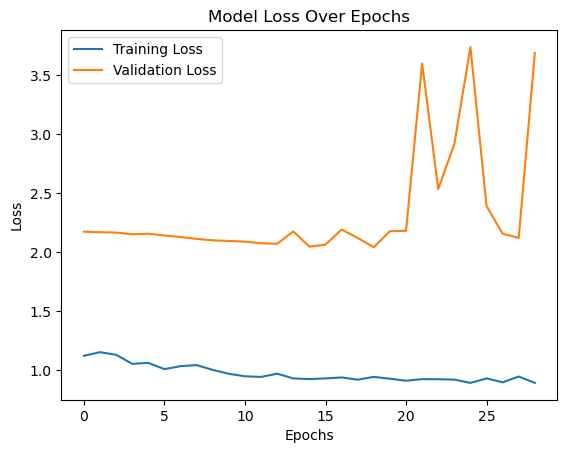

In [246]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Keras Tuner

In [93]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build LSTM model function with hyperparameter choices.
def build_lstm_model_tuner(hp):
    """
    Build an LSTM model for KerasTuner to optimize. Uses only residual sequences for input.
    """

    model = Sequential()

    # Define hyperparameters using `hp` for tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = hp.Choice("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size.

    # Add LSTM layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)  # Return sequences for intermediate layers only.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))
        model.add(BatchNormalization())  # Batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Dropout to combat overfitting.

    # Add the output layer (regression).
    model.add(Dense(1))

    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Print hyperparameters for debugging.
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")

    return model


# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_lstm_model_tuner,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of executions per trial.
    directory="sarimax-lstm",  # Directory to store tuning results.
    project_name="sarimax-lstm",  # Project name for the tuner.
    overwrite=True  # Overwrite previous tuner results if they exist.
)

# Define early stopping to prevent overfitting.
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Perform the hyperparameter search using the residuals (no features).
tuner.search(
    X_train_seq, y_train_seq,  # Training sequences and targets.
    validation_data=(X_test_seq, y_test_seq),  # Validation sequences and targets.
    epochs=200,  # Max number of epochs for each trial.
    callbacks=[early_stopping],  # Early stopping to avoid overfitting.
    shuffle=False,  # Ensure the time series order is preserved.
    verbose=1  # Show progress for each trial.
)

# Retrieve the best model and hyperparameters from the tuner.
best_lstm_model = tuner.get_best_models(num_models=1)[0]
best_lstm_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters found by KerasTuner.
print("Best hyperparameters for LSTM:", best_lstm_hyperparameters.values)
print("Best batch size for LSTM:", best_lstm_hyperparameters.get("batch_size"))

Trial 30 Complete [00h 00m 24s]
val_loss: 2.0023162364959717

Best val_loss So Far: 1.8408759832382202
Total elapsed time: 01h 02m 31s
Built model with params: dropout_rate=0.4, recurrent_dropout=0.2, l2_lambda=0.004687701723470747, learning_rate=0.0001, learning_rate_decay=1e-05, clipnorm=1.0, units=32, num_layers=1, batch_size=64
Best hyperparameters for LSTM: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2, 'l2_lambda': 0.004687701723470747, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 1, 'batch_size': 64}
Best batch size for LSTM: 64


In [249]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0001,
    'l2_lambda': 0.004687701723470747,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 2.1277 - val_loss: 2.2755
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.9412 - val_loss: 2.2718
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.8716 - val_loss: 2.2667
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.6652 - val_loss: 2.2613
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.6367 - val_loss: 2.2564
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.6946 - val_loss: 2.2515
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.5410 - val_loss: 2.2475
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.5180 - val_loss: 2.2421
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.3491 - val_loss: 2.2374
Epoch 10/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.3427 - val_loss: 2.2326
Epoch 11/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.3491 - val_loss: 2.2286
Epoch 12/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
LSTM Model Performance:
Training RMSE: 0.013561535578986976
Test RMSE: 0.020850468723240322
Training MAE: 0.009944920622588336
Test MAE: 0.016609071820481113
Directional Accuracy on Training Data: 67.31470230862698%
Directional Accuracy on Test Data: 63.725490196078425%


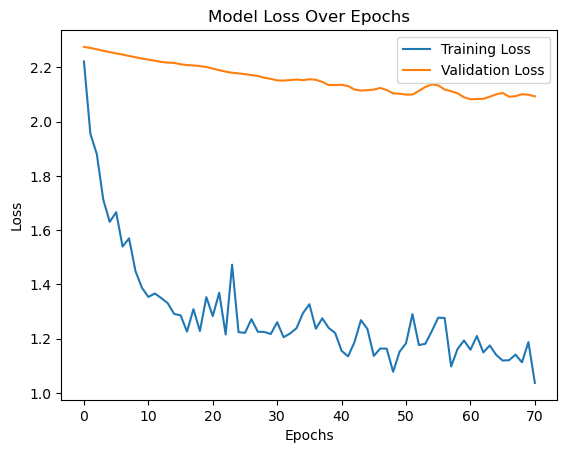

In [250]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Random Search with 2 Layers

In [97]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the LSTM model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.01, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 5.0, 'batch_size': 64}
Final Training Loss: 1.1878806352615356
Final Validation Loss: 2.311439037322998
Running combination 2/30: {'units2': 128, 'units1': 64, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.001, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 1.7974658012390137
Final Validation Loss: 2.7093732357025146
Running combination 3/30: {'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 1.0, 'batch_size': 64}
Final Training Loss: 1.6911133527755737
Final Validation Loss: 2.4203882217407227
Running combination 4

In [269]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0005,
    'l2_lambda': 0.01,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 5.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - loss: 4.0256 - val_loss: 2.7422
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 3.0099 - val_loss: 2.7446
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 2.7093 - val_loss: 2.7450
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 2.5875 - val_loss: 2.7357
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 2.4285 - val_loss: 2.7330
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 2.2189 - val_loss: 2.7328
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 2.1903 - val_loss: 2.7358
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 2.3904 - val_loss: 2.7275
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 2.2715 - val_loss: 2.7213
Epoch 10/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 2.0490 - val_loss: 2.7256
Epoch 11/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 2.1153 - val_loss: 2.7292
Epoch 12/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/st

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
LSTM Model Performance:
Training RMSE: 0.013815717396759292
Test RMSE: 0.02054900619202851
Training MAE: 0.009959878422531926
Test MAE: 0.01612131850643781
Directional Accuracy on Training Data: 63.547995139732684%
Directional Accuracy on Test Data: 67.64705882352942%


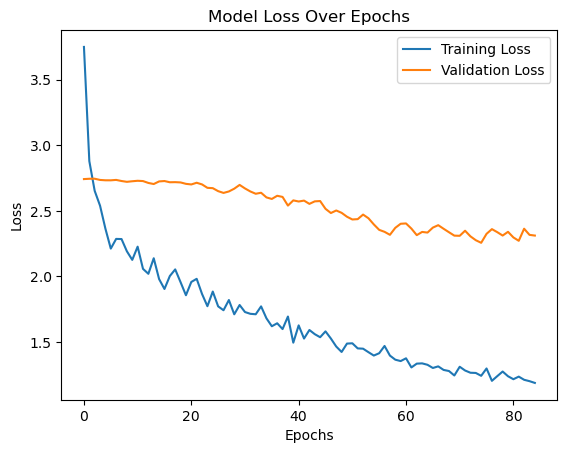

In [270]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Random Search with 3 Layers

In [101]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units3': 32, 'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 5.0, 'batch_size': 32}
Final Training Loss: 1.08970308303833
Final Validation Loss: 2.398447275161743
Running combination 2/30: {'units3': 128, 'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0001, 'l2_lambda': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 4.107224464416504
Final Validation Loss: 4.824799060821533
Running combination 3/30: {'units3': 128, 'units2': 64, 'units1': 64, 'recurrent_dropout': 0.1, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.4, 'clipnorm': 5.0, 'batch_size': 256}
Final Training Loss: 2.896052837371826
Final Validation

In [56]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'units3': 64,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.0001,
    'l2_lambda': 0.001,
    'epochs': 24,
    'dropout_rate': 0.3,
    'clipnorm': 1.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))

        # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/24
26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 103ms/step - loss: 3.5880 - val_loss: 2.3019
Epoch 2/24
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 2.5398 - val_loss: 2.2943
Epoch 3/24
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 2.6055 - val_loss: 2.2869
Epoch 4/24
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 2.4538 - val_loss: 2.2782
Epoch 5/24
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 2.1304 - val_loss: 2.2697
Epoch 6/24
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 2.3033 - val_loss: 2.2578
Epoch 7/24
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 2.1364 - val_loss: 2.2396
Epoch 8/24
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 2.0005 - val_loss: 2.2158
Epoch 9/24
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 2.1194 - val_loss: 2.2058
Epoch 10/24
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 1.8663 - val_loss: 2.1739
Epoch 11/24
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 2.1238 - val_loss: 2.1444
Epoch 12/24
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 1

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
LSTM Model Performance:
Training RMSE: 0.014161610342546913
Test RMSE: 0.019704063674579338
Training MAE: 0.010416235845063317
Test MAE: 0.01572860734008331
Directional Accuracy on Training Data: 64.27703523693803%
Directional Accuracy on Test Data: 75.49019607843137%


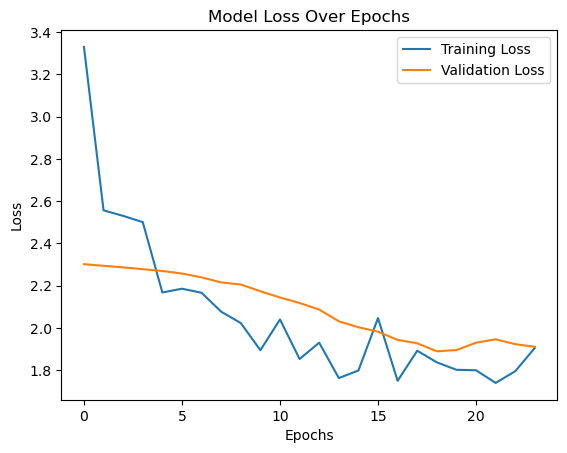

In [57]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [58]:
# Extract scaled train and validation loss from history
scaled_train_loss = history.history['loss'][-1]  # Final train loss
scaled_val_loss = history.history['val_loss'][-1]  # Final validation loss

# Retrieve the center (median) and scale (IQR) from the RobustScaler
center = scaler.center_[0]  # Median used by the RobustScaler
scale = scaler.scale_[0]    # IQR used by the RobustScaler

# Descale the train and validation losses
descaled_train_loss = scaled_train_loss * scale + center
descaled_val_loss = scaled_val_loss * scale + center

# Print the descaled losses
print(f"Descaled Training Loss: {descaled_train_loss}")
print(f"Descaled Validation Loss: {descaled_val_loss}")

Descaled Training Loss: 0.027921850461499753
Descaled Validation Loss: 0.027992831371426646


### Model Performance Comparison (Sequence Length = 52)

| **Metric**            | **Random Search (Optuna)** | **Keras Tuner**       | **Random Search (2 Layers)** | **Random Search (3 Layers)** |
|------------------------|---------------------------|-----------------------|------------------------------|------------------------------|
| **Train RMSE**         | 0.015840356              | 0.013561536           | 0.013815717                  | 0.014161610                  |
| **Test RMSE**          | 0.021035744              | 0.020850469           | 0.020549006                  | 0.019704064                  |
| **Train MAE**          | 0.013283320              | 0.009944921           | 0.009959878                  | 0.010416236                  |
| **Test MAE**           | 0.016757018              | 0.016609072           | 0.016121319                  | 0.015728607                  |
| **Train Loss**         | 0.894823790              | 1.037143350           | 1.187880635                  | 1.905864596                  |
| **Validation Loss**    | 3.689065456              | 2.093481064           | 2.311439037                  | 1.911043406                  |
| **Train DA**           | 70.60%                   | 67.31%                | 63.55%                       | 64.28%                       |
| **Test DA**            | 65.69%                   | 63.73%                | 67.65%                       | 75.49%                       |

**Best Model**: **Random Search with 3 Layers**



The score metrics table indicates that the best performer using the sequence length of 52 is with the random search parameters (3 layers). The model resulted in lowest metrics for the test set (RMSE and MAE). Also, the model achieved the highest DA. 
The train and val plot shows that despite having higher train and val loss (compare to shorter SL), the convergence is okay. 


### Cross-Validation Results for SL = 52 (Best Model)

#### **Training and Validation Loss**
| **Metric**           | **Loss**         |
|-----------------------|------------------|
| **Training Loss**     | 0.02792185       |
| **Validation Loss**   | 0.02799283       |

#### **TSCV RMSE Values**
| **Fold** | **RMSE**         |
|----------|------------------|
| **1**    | 0.02158975       |
| **2**    | 0.01197836       |
| **3**    | 0.01230295       |
| **4**    | 0.01776838       |

**Average TSCV RMSE**: **0.01590986**

- Like previous sequence lengths, the performance on different splits remained the same as others. The values increased a little if compare with shorter SL. The first and second folds presents RMSE above average, which may represent high volatility, extreme values within the folds.

#### **FRWCV RMSE Values**
| **Window** | **RMSE**         |
|------------|------------------|
| **1**      | 0.01815840       |
| **2**      | 0.01125107       |
| **3**      | 0.01388746       |
| **4**      | 0.00872875       |
| **5**      | 0.01575941       |

**Average FRWCV RMSE**: **0.01355702**

- The current model also shows similar performance regarind FRWCV, underperforming in the first and last window (above rmse avg). Showing ability to adapt to evolving trends. 

In [59]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'units3': 64,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.0001,
    'l2_lambda': 0.001,
    'epochs': 24,
    'dropout_rate': 0.3,
    'clipnorm': 1.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))

        # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    optimizer = Adam(learning_rate=params['learning_rate'], 
                     decay=params['learning_rate_decay'], 
                     clipnorm=params['clipnorm'])
    
    # Compile the model
    model.compile(optimizer=optimizer, loss=params['loss_function'])
    
    return model

# Define the number of splits for Time Series Cross-Validation
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize the list to store RMSE scores
tscv_rmse_scores = []

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create the model once and save its initial weights
model = build_best_model(best_params)
initial_weights = model.get_weights()

# Perform TSCV
for fold, (train_index, test_index) in enumerate(tscv.split(y_train_scaled)):
    print(f"Fold {fold + 1}")

    # Reset model to initial weights
    model.set_weights(initial_weights)
    
    # Define train and test sets
    y_train_fold, y_test_fold = y_train_scaled[train_index], y_train_scaled[test_index]
    
    # Create sequences for TSCV
    X_train_seq, y_train_seq = [], []
    for i in range(len(y_train_fold) - sequence_length):
        X_train_seq.append(y_train_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_train_seq.append(y_train_fold[i + sequence_length])    # Next residual value as target.
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(y_test_fold) - sequence_length):
        X_test_seq.append(y_test_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_test_seq.append(y_test_fold[i + sequence_length])    # Next residual value as target.
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        verbose=0,
        callbacks=[early_stopping]
    )
    
    # Predict and evaluate
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    tscv_rmse_scores.append(rmse)
    print(f"Fold {fold + 1} RMSE: {rmse}")

# Calculate the average RMSE across all folds
avg_rmse = np.mean(tscv_rmse_scores)
print(f"Average RMSE from TSCV: {avg_rmse}")

Fold 1
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 312ms/step
Fold 1 RMSE: 1.4438711245974114
Fold 2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Fold 2 RMSE: 0.7426184792515588
Fold 3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Fold 3 RMSE: 0.7663006756887376
Fold 4
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Fold 4 RMSE: 1.1650613430685388
Average RMSE from TSCV: 1.0294629056515616


In [60]:
# Parameters for FRWCV
train_window = 300  # Training window size
test_window = 100    # Test window size

# Store RMSEs for each window
rolling_rmse_scores = []

for start in range(0, len(y_train_scaled) - train_window - test_window, test_window):
    print(f"Rolling window starting at index {start}")
    
    # Define train and test sets for the window
    y_train_fold = y_train_scaled[start:start + train_window]
    y_test_fold = y_train_scaled[start + train_window:start + train_window + test_window]
    
    # Create sequences for FRWCV
    X_train_seq, y_train_seq = [], []
    for i in range(len(y_train_fold) - sequence_length):
        X_train_seq.append(y_train_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_train_seq.append(y_train_fold[i + sequence_length])    # Next residual value as target.
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(y_test_fold) - sequence_length):
        X_test_seq.append(y_test_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_test_seq.append(y_test_fold[i + sequence_length])    # Next residual value as target.
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    model.set_weights(initial_weights)  # Reset to initial weights
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=best_params['epochs'], 
        batch_size=best_params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        verbose=0,  # Suppress training logs for brevity
        callbacks=[early_stopping]
    )
    
    # Evaluate on the test set
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    rolling_rmse_scores.append(rmse)
    print(f"Rolling window RMSE: {rmse}")

# Calculate average RMSE across rolling windows
avg_rolling_rmse = np.mean(rolling_rmse_scores)
print(f"Average Rolling Window RMSE: {avg_rolling_rmse}")

Rolling window starting at index 0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Rolling window RMSE: 1.1935171933433768
Rolling window starting at index 100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Rolling window RMSE: 0.6895543534793633
Rolling window starting at index 200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Rolling window RMSE: 0.8819075045278866
Rolling window starting at index 300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Rolling window RMSE: 0.5055246184903416
Rolling window starting at index 400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Rolling window RMSE: 1.0184854634745841
Average Rolling Window RMSE: 0.8577978266631104


In [61]:
# Function to descale RMSE
def descale_rmse(scaled_rmse, scaler):
    # Reshape RMSE value to fit scaler requirements
    scaled_rmse_array = np.array(scaled_rmse).reshape(-1, 1)
    # Inverse transform the RMSE
    descaled_rmse_array = scaler.inverse_transform(scaled_rmse_array)
    # Return the descaled RMSE as a list
    return descaled_rmse_array.flatten().tolist()

# Descale TSCV RMSE values
descaled_tscv_rmse = descale_rmse(tscv_rmse_scores, scaler)
print("Descaled TSCV RMSE Values:", descaled_tscv_rmse)

# Descale FRWCV RMSE values
descaled_frwcv_rmse = descale_rmse(rolling_rmse_scores, scaler)
print("Descaled FRWCV RMSE Values:", descaled_frwcv_rmse)

# Calculates average descaled RMSE
average_tscv_rmse = np.mean(descaled_tscv_rmse)
average_frwcv_rmse = np.mean(descaled_frwcv_rmse)
print(f"Average Descaled TSCV RMSE: {average_tscv_rmse}")
print(f"Average Descaled FRWCV RMSE: {average_frwcv_rmse}")

Descaled TSCV RMSE Values: [0.021589754422499014, 0.011978365151290941, 0.012302954028446167, 0.017768379400700928]
Descaled FRWCV RMSE Values: [0.018158396117001218, 0.011251066691145558, 0.013887464606420496, 0.008728749759871238, 0.01575940610712795]
Average Descaled TSCV RMSE: 0.015909863250734263
Average Descaled FRWCV RMSE: 0.013557016656313292


## Evaluation of optimal model for Robust Scaler

### Best Model Performance Across Sequence Lengths (SL)

| **Sequence Length (SL)** | **Train RMSE** | **Test RMSE** | **Train MAE** | **Test MAE** | **Train DA** | **Test DA** | **Train Loss** | **Validation Loss** |
|---------------------------|----------------|---------------|---------------|--------------|--------------|-------------|----------------|---------------------|
| **4**                    | 0.013511580    | 0.018313618   | 0.010048385   | 0.013946860  | 60.39%       | 70.67%      | 0.9472         | 1.9137              |
| **12**                   | 0.015134038    | 0.017709847   | 0.010599869   | 0.013404791  | 69.99%       | 71.13%      | 0.9165         | 1.8008              |
| **26**                   | 0.018747995    | 0.018065793   | 0.012678031   | 0.013946646  | 63.25%       | 72.66%      | 0.9137         | 1.7000              |
| **52**                   | 0.014161610    | 0.019704064   | 0.010416236   | 0.015728607  | 64.28%       | 75.49%      | 1.9059         | 1.9110              |

- When comparing the score metrics across different sequence length, the SL = 12 and 26 are the ones that stands out, presenting the lower RMSE and MAE metrics, so as the DA.

### TSCV RMSE Comparison

| **Sequence Length (SL)** | **Fold 1 RMSE** | **Fold 2 RMSE** | **Fold 3 RMSE** | **Fold 4 RMSE** | **Average TSCV RMSE** | **Training Loss** | **Validation Loss** |
|---------------------------|-----------------|-----------------|-----------------|-----------------|------------------------|-------------------|---------------------|
| **SL = 4**               | 0.02021290      | 0.01422077      | 0.01233996      | 0.01625720      | **0.01575771**         | 0.01478191        | 0.02802864          |
| **SL = 12**              | 0.02023338      | 0.01418727      | 0.01271732      | 0.01650192      | **0.01591000**         | 0.01436211        | 0.02648131          |
| **SL = 26**              | 0.02094209      | 0.01428537      | 0.01228780      | 0.01702989      | **0.01474769**         | 0.01432316        | 0.02510021          |
| **SL = 52**              | 0.02158975      | 0.01197836      | 0.01230295      | 0.01776838      | **0.01590986**         | 0.02792185        | 0.02799283          |

- Validating the model across different splits (TSCV with 4 splits), the model that presented the best average across all folds was the model using SL = 26, the only one to score less than 0.015.
  
---

### FRWCV RMSE Comparison

| **Sequence Length (SL)** | **Window 1 RMSE** | **Window 2 RMSE** | **Window 3 RMSE** | **Window 4 RMSE** | **Window 5 RMSE** | **Average FRWCV RMSE** |
|---------------------------|-------------------|-------------------|-------------------|-------------------|-------------------|------------------------|
| **SL = 4**               | 0.01753545        | 0.01225658        | 0.01276241        | 0.01116210        | 0.01376321        | **0.01349595**         |
| **SL = 12**              | 0.01809409        | 0.01245716        | 0.01344320        | 0.01129898        | 0.01449306        | **0.01395730**         |
| **SL = 26**              | 0.01714008        | 0.01244101        | 0.01344710        | 0.00921653        | 0.01474769        | **0.01339848**         |
| **SL = 52**              | 0.01815840        | 0.01125107        | 0.01388746        | 0.00872875        | 0.01575941        | **0.01355702**         |

- Using a different type of cross-validation, the lowest score was registered for the SL = 26.

---

### Model Selection Justification 

**The optimal model for the Robust scaler (residuals) is using the sequence length of 26**, the model achieved:
- The second lowest RMSE and MAE metrics.
- Lowest validation loss and shortest gap between train and val loss, meaning that among the models is the one that has better generalization.
- On both cross-validation techniques applied, the SL = 26 was the one that scored the lowest average values for TSCV and FRWCV. 

In [18]:
# Reshape residual data into sequences for LSTM.
sequence_length = 26  # Number of time steps used for target prediction.

# Initialize empty lists for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the scaled training residuals to create sequences and targets.
for i in range(len(y_train_scaled) - sequence_length):
    X_train_seq.append(y_train_scaled[i:i + sequence_length])  # Sequence of past residuals.
    y_train_seq.append(y_train_scaled[i + sequence_length])    # Next residual value as target.

# Initialize empty lists for the test set.
X_test_seq, y_test_seq = [], []
# Loop through the scaled test residuals to create sequences and targets.
for i in range(len(y_test_scaled) - sequence_length):
    X_test_seq.append(y_test_scaled[i:i + sequence_length])  # Sequence of past residuals.
    y_test_seq.append(y_test_scaled[i + sequence_length])    # Next residual value as target.

# Convert lists to numpy arrays to use in LSTM model.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input and target data shapes for verification.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}") 
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}") 
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")    
print(f"Reshaped y_test_seq shape: {y_test_seq.shape}")    

Reshaped X_train_seq shape: (850, 26, 1)
Reshaped y_train_seq shape: (850, 1)
Reshaped X_test_seq shape: (129, 26, 1)
Reshaped y_test_seq shape: (129, 1)


In [19]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0005,
    'l2_lambda': 0.1,
    'epochs': 100,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))

        # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 12.4379 - val_loss: 11.3835
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 10.9729 - val_loss: 10.4346
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.7779 - val_loss: 9.5165
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.8732 - val_loss: 8.6740
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.0195 - val_loss: 7.9218
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.1958 - val_loss: 7.2693
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.5383 - val_loss: 6.6881
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.0017 - val_loss: 6.1740
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.5824 - val_loss: 5.7343
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.0446 - val_loss: 5.3664
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.5489 - val_loss: 5.0170
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
LSTM Model Performance:
Training RMSE: 0.018747995012072104
Test RMSE: 0.018065793008686847
Training MAE: 0.012678031335398271
Test MAE: 0.013946645607206367
Directional Accuracy on Training Data: 63.25088339222616%
Directional Accuracy on Test Data: 72.65625%


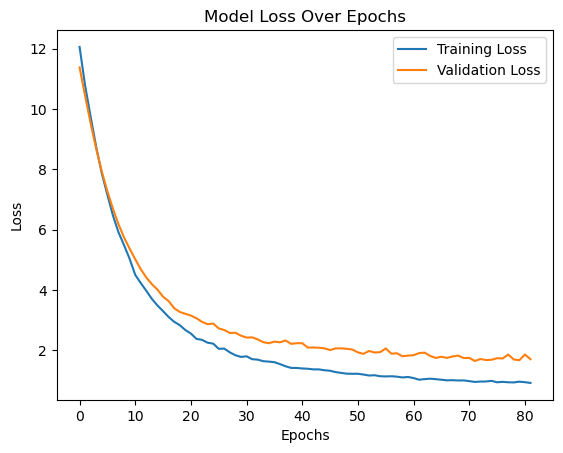

In [20]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
# Predict residuals for the training set
lstm_train_residuals = model.predict(X_train_seq)
lstm_train_residuals = scaler.inverse_transform(lstm_train_residuals)

# Predict residuals for the test set
lstm_test_residuals = model.predict(X_test_seq)
lstm_test_residuals = scaler.inverse_transform(lstm_test_residuals)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [22]:
# Truncate SARIMAX predictions to align with LSTM predictions
aligned_train_predictions = train_predictions[sequence_length:]  # SL = 26
aligned_test_predictions = test_predictions[sequence_length:]

# Combine SARIMAX and LSTM predictions
hybrid_train_predictions = aligned_train_predictions + lstm_train_residuals.flatten()
hybrid_test_predictions = aligned_test_predictions + lstm_test_residuals.flatten()

# Validate shapes
print(f"Hybrid Train Predictions Length: {len(hybrid_train_predictions)}")
print(f"Hybrid Test Predictions Length: {len(hybrid_test_predictions)}")

Hybrid Train Predictions Length: 850
Hybrid Test Predictions Length: 129


In [23]:
# Align train dataset by truncating the first SL points
aligned_train = train[sequence_length:] 

# Align test dataset by truncating the first SL points
aligned_test = test[sequence_length:]  

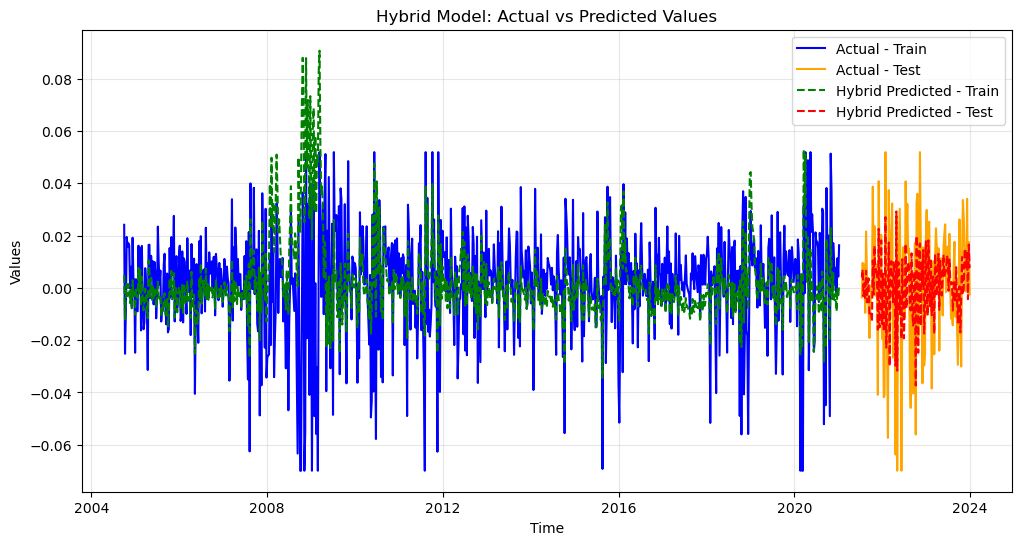

In [24]:
# Ensure hybrid test predictions are properly indexed
hybrid_test_predictions = pd.Series(hybrid_test_predictions, index=aligned_test.index)

# Plot actual vs hybrid predictions for training and test sets
plt.figure(figsize=(12, 6))
plt.plot(aligned_train.index, aligned_train, label="Actual - Train", color="blue")
plt.plot(aligned_test.index, aligned_test, label="Actual - Test", color="orange")
plt.plot(aligned_train.index, hybrid_train_predictions, label="Hybrid Predicted - Train", linestyle="--", color="green")
plt.plot(aligned_test.index, hybrid_test_predictions, label="Hybrid Predicted - Test", linestyle="--", color="red")

# Finalize plot
plt.legend()
plt.title("Hybrid Model: Actual vs Predicted Values")
plt.xlabel("Time")
plt.ylabel("Values")
plt.grid(alpha=0.3)
plt.show()

In [25]:
# Function to calculate Directional Accuracy
def directional_accuracy(actual, predicted):
    # Compare the direction of changes (increase or decrease) between actual and predicted values
    actual_direction = np.sign(np.diff(actual))
    predicted_direction = np.sign(np.diff(predicted))
    correct_directions = np.sum(actual_direction == predicted_direction)
    total_directions = len(actual_direction)
    return (correct_directions / total_directions) * 100

# Evaluate hybrid model on training data
hybrid_train_rmse = mean_squared_error(aligned_train, hybrid_train_predictions, squared=False)
hybrid_train_mae = mean_absolute_error(aligned_train, hybrid_train_predictions)
hybrid_train_da = directional_accuracy(aligned_train, hybrid_train_predictions)

# Evaluate hybrid model on testing data
hybrid_test_rmse = mean_squared_error(aligned_test, hybrid_test_predictions, squared=False)
hybrid_test_mae = mean_absolute_error(aligned_test, hybrid_test_predictions)
hybrid_test_da = directional_accuracy(aligned_test, hybrid_test_predictions)

# Print metrics
print(f"Hybrid Training RMSE: {hybrid_train_rmse}")
print(f"Hybrid Test RMSE: {hybrid_test_rmse}")
print(f"Hybrid Training MAE: {hybrid_train_mae}")
print(f"Hybrid Test MAE: {hybrid_test_mae}")
print(f"Hybrid Training Directional Accuracy: {hybrid_train_da:.2f}%")
print(f"Hybrid Test Directional Accuracy: {hybrid_test_da:.2f}%")

Hybrid Training RMSE: 0.018747995012072104
Hybrid Test RMSE: 0.018065793008686847
Hybrid Training MAE: 0.012678031335398271
Hybrid Test MAE: 0.013946645607206367
Hybrid Training Directional Accuracy: 90.11%
Hybrid Test Directional Accuracy: 75.78%


In [26]:
# Define TSCV
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)
tscv_rmse_scores = []

# Perform TSCV
for fold, (train_index, test_index) in enumerate(tscv.split(train)):
    print(f"Fold {fold + 1}")
    
    # Split data into train and validation sets
    train_fold, test_fold = train.iloc[train_index], train.iloc[test_index]
    exo_train_fold, exo_test_fold = exo_train.iloc[train_index], exo_train.iloc[test_index]

    # Step 1: Train SARIMAX on the training fold
    sarimax_model = SARIMAX(train_fold, order=(1, 0, 3), seasonal_order=(1, 0, 2, 52), exog=exo_train_fold)
    sarimax_result = sarimax_model.fit(disp=False)

    # Predict using SARIMAX
    train_predictions = sarimax_result.predict(start=0, end=len(train_fold)-1, exog=exo_train_fold)
    test_predictions = sarimax_result.forecast(steps=len(test_fold), exog=exo_test_fold)

    # Step 2: Calculate residuals for LSTM
    residuals_train = train_fold - train_predictions
    residuals_test = test_fold - test_predictions

    # Scale residuals
    residuals_train_scaled = scaler.fit_transform(residuals_train.values.reshape(-1, 1))
    residuals_test_scaled = scaler.transform(residuals_test.values.reshape(-1, 1))

    # Create sequences for LSTM
    X_train_seq, y_train_seq = [], []
    for i in range(len(residuals_train_scaled) - sequence_length):
        X_train_seq.append(residuals_train_scaled[i:i + sequence_length])
        y_train_seq.append(residuals_train_scaled[i + sequence_length])
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)

    X_test_seq, y_test_seq = [], []
    for i in range(len(residuals_test_scaled) - sequence_length):
        X_test_seq.append(residuals_test_scaled[i:i + sequence_length])
        y_test_seq.append(residuals_test_scaled[i + sequence_length])
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

    # Step 3: Train LSTM on residuals
    lstm_model = build_best_model(best_params)
    history = lstm_model.fit(
        X_train_seq, y_train_seq, 
        epochs=best_params['epochs'], 
        batch_size=best_params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        verbose=0,
        callbacks=[early_stopping]
    )

    # Predict residuals using LSTM
    lstm_residual_predictions = lstm_model.predict(X_test_seq)
    lstm_residual_predictions = scaler.inverse_transform(lstm_residual_predictions)

    # Combine SARIMAX and LSTM predictions
    hybrid_predictions = test_predictions[sequence_length:] + lstm_residual_predictions.flatten()

    # Evaluate hybrid model
    actual_values = test_fold.iloc[sequence_length:]
    rmse = np.sqrt(mean_squared_error(actual_values, hybrid_predictions))
    tscv_rmse_scores.append(rmse)
    print(f"Fold {fold + 1} RMSE: {rmse}")

# Calculate average RMSE across folds
avg_tscv_rmse = np.mean(tscv_rmse_scores)
print(f"Average TSCV RMSE: {avg_tscv_rmse}")

Fold 1
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
Fold 1 RMSE: 0.02414703798277943
Fold 2
1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 337ms/stepWARNING:tensorflow:5 out of the last 48 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000014B9DBDDF80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
Fold 2 RMSE: 0.015467794387278536
Fold 3
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
Fold 3 RMSE: 0.012869282625699077

In [27]:
# Define FRWCV parameters
train_window = 300
test_window = 50
rolling_rmse_scores = []

# Perform FRWCV
for start in range(0, len(train) - train_window - test_window, test_window):
    print(f"Rolling window starting at index {start}")
    
    # Define training and test sets
    train_fold = train[start:start + train_window]
    test_fold = train[start + train_window:start + train_window + test_window]
    exo_train_fold = exo_train[start:start + train_window]
    exo_test_fold = exo_train[start + train_window:start + train_window + test_window]

    # Step 1: Train SARIMAX on the training window
    sarimax_model = SARIMAX(train_fold, order=(1, 0, 3), seasonal_order=(1, 0, 2, 52), exog=exo_train_fold)
    sarimax_result = sarimax_model.fit(disp=False)

    # Predict using SARIMAX
    train_predictions = sarimax_result.predict(start=0, end=len(train_fold)-1, exog=exo_train_fold)
    test_predictions = sarimax_result.forecast(steps=len(test_fold), exog=exo_test_fold)

    # Step 2: Calculate residuals for LSTM
    residuals_train = train_fold - train_predictions
    residuals_test = test_fold - test_predictions

    # Scale residuals
    residuals_train_scaled = scaler.fit_transform(residuals_train.values.reshape(-1, 1))
    residuals_test_scaled = scaler.transform(residuals_test.values.reshape(-1, 1))

    # Create sequences for LSTM
    X_train_seq, y_train_seq = [], []
    for i in range(len(residuals_train_scaled) - sequence_length):
        X_train_seq.append(residuals_train_scaled[i:i + sequence_length])
        y_train_seq.append(residuals_train_scaled[i + sequence_length])
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)

    X_test_seq, y_test_seq = [], []
    for i in range(len(residuals_test_scaled) - sequence_length):
        X_test_seq.append(residuals_test_scaled[i:i + sequence_length])
        y_test_seq.append(residuals_test_scaled[i + sequence_length])
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

    # Step 3: Train LSTM on residuals
    lstm_model = build_best_model(best_params)
    history = lstm_model.fit(
        X_train_seq, y_train_seq, 
        epochs=best_params['epochs'], 
        batch_size=best_params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        verbose=0,
        callbacks=[early_stopping]
    )

    # Predict residuals using LSTM
    lstm_residual_predictions = lstm_model.predict(X_test_seq)
    lstm_residual_predictions = scaler.inverse_transform(lstm_residual_predictions)

    # Combine SARIMAX and LSTM predictions
    hybrid_predictions = test_predictions[sequence_length:] + lstm_residual_predictions.flatten()

    # Evaluate hybrid model
    actual_values = test_fold.iloc[sequence_length:]
    rmse = np.sqrt(mean_squared_error(actual_values, hybrid_predictions))
    rolling_rmse_scores.append(rmse)
    print(f"Rolling window RMSE: {rmse}")

# Calculate average RMSE across windows
avg_rolling_rmse = np.mean(rolling_rmse_scores)
print(f"Average Rolling Window RMSE: {avg_rolling_rmse}")

Rolling window starting at index 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
Rolling window RMSE: 0.016525203731995737
Rolling window starting at index 50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
Rolling window RMSE: 0.024052844381357304
Rolling window starting at index 100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
Rolling window RMSE: 0.012693876006669325
Rolling window starting at index 150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
Rolling window RMSE: 0.01626477481334082
Rolling window starting at index 200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
Rolling window RMSE: 0.010663335414660406
Rolling window starting at index 250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
Rolling window RMSE: 0.016078649716143065
Rolling window starting at index 300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
Rolling window RMSE: 0.012328309330700442
Rolling window starting at index 350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
Rolling window RMSE: 0.007087822314536305
Rolling window starting at index 400
1/1 ━━━━━━━━━━━━━━━━━━━